In [1]:
import keras
import tensorflow as tf
import pandas as pd
import seaborn as sns
from keras.callbacks import ModelCheckpoint,EarlyStopping
tf.__version__

'2.3.0'

# Machine learning using Tensorflow

## Import data

In [2]:
# Import data
# Predict survial

Train = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
Test = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')

In [3]:
X_Train = Train.drop('survived', axis=1)
X_Test = Test.drop('survived', axis=1)

y_Train = Train[['survived']]
y_Test = Test[['survived']]

## EDA


/opt/anaconda3/envs/buddy/lib/python3.8/site-packages/seaborn/axisgrid.py:1912: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


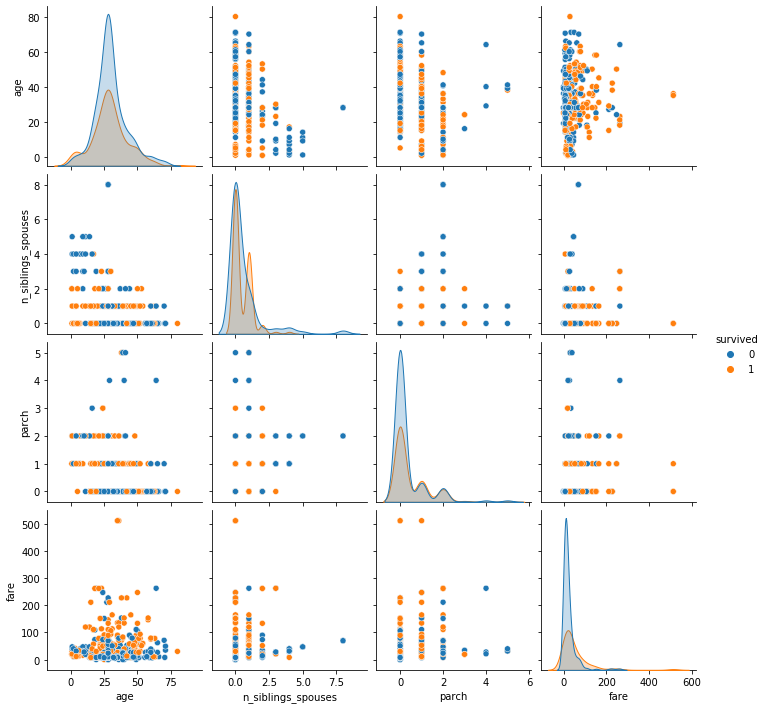

In [4]:
observing_columns = "survived"

sns.pairplot(Train, size = 2.5, hue=observing_columns)

In [5]:
set(Train['embark_town'])

{'Cherbourg', 'Queenstown', 'Southampton', 'unknown'}

In [6]:
col = "embark_town"
pd.DataFrame({"Total": Train.groupby(col).count()['survived'],
              "p(survived| feature)": Train.groupby(col).sum()['survived'] / Train.shape[1]})

,Total,p(survived| feature)
embark_town,,
Cherbourg,123,7.3
Queenstown,53,1.9
Southampton,450,15.0
unknown,1,0.1


In [7]:
for col in Train.columns:
    if Test[col].dtype == object:
        print(pd.DataFrame({"Total": Train.groupby(col).count()['survived'],
              "p(survived)": Train.groupby(col).sum()['survived'] / Train.shape[0]}))
        print('-'*36)
             

        Total  p(survived)
sex                       
female    217     0.269537
male      410     0.118022
------------------------------------
        Total  p(survived)
class                     
First     159     0.161085
Second    127     0.092504
Third     341     0.133971
------------------------------------
         Total  p(survived)
deck                       
A           11     0.007974
B           37     0.041467
C           43     0.038278
D           22     0.027113
E           23     0.027113
F            6     0.004785
G            4     0.003190
unknown    481     0.237640
------------------------------------
             Total  p(survived)
embark_town                    
Cherbourg      123     0.116427
Queenstown      53     0.030303
Southampton    450     0.239234
unknown          1     0.001595
------------------------------------
       Total  p(survived)
alone                    
n        255     0.205742
y        372     0.181818
---------------------------------

In [8]:
X_Test.drop(X_Test[X_Test['embark_town'] == 'unknown'].index)

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,35.0,0,0,8.0500,Third,unknown,Southampton,y
1,male,54.0,0,0,51.8625,First,E,Southampton,y
2,female,58.0,0,0,26.5500,First,C,Southampton,y
3,female,55.0,0,0,16.0000,Second,unknown,Southampton,y
4,male,34.0,0,0,13.0000,Second,D,Southampton,y
...,...,...,...,...,...,...,...,...,...
259,female,25.0,0,1,26.0000,Second,unknown,Southampton,n
260,male,33.0,0,0,7.8958,Third,unknown,Southampton,y
261,female,39.0,0,5,29.1250,Third,unknown,Queenstown,n
262,male,27.0,0,0,13.0000,Second,unknown,Southampton,y


## Preprocessing

In [9]:
try:
    X_Train, X_Test = X_Train.drop('deck', axis = 1), X_Test.drop('deck', axis = 1)
except KeyError:
    pass

X_Train = X_Train.drop(X_Train[X_Train['embark_town'] == 'unknown'].index)
X_Test = X_Test.drop(X_Test[X_Test['embark_town'] == 'unknown'].index)

cat_cols = [] #Categories
for col in X_Train.columns:
    if X_Test[col].dtype == object:
        cat_cols.append(col)

## One hot encoder

In [10]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')

enc.fit(X_Train[cat_cols])
cat_array = enc.transform(X_Train[cat_cols]).toarray()
cat_df = pd.DataFrame(cat_array, columns=enc.get_feature_names(cat_cols), index= X_Train.index)

X_Train_pre = pd.concat([X_Train, cat_df], axis = 1).drop(cat_cols, axis = 1)

cat_array = enc.transform(X_Test[cat_cols]).toarray()
cat_df = pd.DataFrame(cat_array, columns=enc.get_feature_names(cat_cols), index= X_Test.index)

X_Test_pre = pd.concat([X_Test, cat_df], axis = 1).drop(cat_cols, axis = 1)



In [11]:
X_Test_pre

,age,n_siblings_spouses,parch,fare,sex_female,sex_male,class_First,class_Second,class_Third,embark_town_Cherbourg,embark_town_Queenstown,embark_town_Southampton,alone_n,alone_y
0,35.0,0,0,8.0500,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
1,54.0,0,0,51.8625,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,58.0,0,0,26.5500,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,55.0,0,0,16.0000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
4,34.0,0,0,13.0000,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,25.0,0,1,26.0000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
260,33.0,0,0,7.8958,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
261,39.0,0,5,29.1250,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
262,27.0,0,0,13.0000,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0


In [12]:
y_Train = y_Train.loc[X_Train_pre.index]
y_Test = y_Test.loc[X_Test_pre.index]

In [13]:
format(0.555,'.2')

'0.56'

## Create models

In [14]:
from keras.layers import (Input, Concatenate, concatenate,
                          BatchNormalization, Conv2D, Flatten, Dense)

from keras.models import Model, load_model

def getCheckPoint(filepath, monitor, verbose=1, mode='min'):
    return ModelCheckpoint(filepath,
                           monitor=monitor,
                           verbose=verbose,
                           save_best_only=True,
                           include_optimizer = False,
                           mode=mode)

def getEarlyStop(monitor, verbose=1, mode='min'):
    return EarlyStopping(monitor=monitor, mode = 'min', patience=5)

# Get get hyper param
early_stop = getEarlyStop('val_loss')
# checkpoint = getCheckPoint('Best_model_with_{val_loss:.5}.model', 'val_loss')

checkpoint = getCheckPoint('Best_model.model', 'val_loss')
InputLayer = Input(shape=(X_Train_pre.shape[1]))
OutputLayer = Dense(1, activation='sigmoid')(InputLayer)

model = Model(inputs=InputLayer, outputs=OutputLayer)

model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer='adam')

model.summary()

# model.fit(X_Train_pre, y_Train, epochs=5)

hist = model.fit(X_Train_pre, y_Train,
                    validation_data=(X_Test_pre, y_Test), #Tuple only
                    epochs=100,
                    callbacks = [checkpoint, early_stop],
                    verbose=2)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 14)]              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 15        
Total params: 15
Trainable params: 15
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100

Epoch 00001: val_loss improved from inf to 5.69608, saving model to Best_model.model
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: Best_model.model/assets
20/20 - 0s - loss: 7.9285 - val_loss: 5.6961
Epoch 2/100

Epoch 00002: val_loss improved from 5.69608 to 5.34538, saving model to

INFO:tensorflow:Assets written to: Best_model.model/assets
20/20 - 0s - loss: 0.5200 - val_loss: 0.5363
Epoch 35/100

Epoch 00035: val_loss improved from 0.53630 to 0.53475, saving model to Best_model.model
INFO:tensorflow:Assets written to: Best_model.model/assets
20/20 - 0s - loss: 0.5182 - val_loss: 0.5348
Epoch 36/100

Epoch 00036: val_loss improved from 0.53475 to 0.53377, saving model to Best_model.model
INFO:tensorflow:Assets written to: Best_model.model/assets
20/20 - 0s - loss: 0.5171 - val_loss: 0.5338
Epoch 37/100

Epoch 00037: val_loss improved from 0.53377 to 0.53281, saving model to Best_model.model
INFO:tensorflow:Assets written to: Best_model.model/assets
20/20 - 0s - loss: 0.5157 - val_loss: 0.5328
Epoch 38/100

Epoch 00038: val_loss improved from 0.53281 to 0.53093, saving model to Best_model.model
INFO:tensorflow:Assets written to: Best_model.model/assets
20/20 - 0s - loss: 0.5140 - val_loss: 0.5309
Epoch 39/100

Epoch 00039: val_loss improved from 0.53093 to 0.53025

INFO:tensorflow:Assets written to: Best_model.model/assets
20/20 - 0s - loss: 0.4698 - val_loss: 0.5050
Epoch 78/100

Epoch 00078: val_loss improved from 0.50497 to 0.50398, saving model to Best_model.model
INFO:tensorflow:Assets written to: Best_model.model/assets
20/20 - 0s - loss: 0.4693 - val_loss: 0.5040
Epoch 79/100

Epoch 00079: val_loss did not improve from 0.50398
20/20 - 0s - loss: 0.4682 - val_loss: 0.5052
Epoch 80/100

Epoch 00080: val_loss did not improve from 0.50398
20/20 - 0s - loss: 0.4676 - val_loss: 0.5045
Epoch 81/100

Epoch 00081: val_loss improved from 0.50398 to 0.50308, saving model to Best_model.model
INFO:tensorflow:Assets written to: Best_model.model/assets
20/20 - 0s - loss: 0.4667 - val_loss: 0.5031
Epoch 82/100

Epoch 00082: val_loss improved from 0.50308 to 0.50270, saving model to Best_model.model
INFO:tensorflow:Assets written to: Best_model.model/assets
20/20 - 0s - loss: 0.4656 - val_loss: 0.5027
Epoch 83/100

Epoch 00083: val_loss improved from 0.502

In [15]:
model_ = load_model('Best_model.model')

In [16]:
model_.optimizer

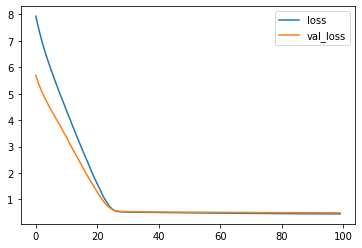

In [17]:
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')

plt.legend()

In [18]:
min(hist.history['val_loss'])

0.495818167924881

# Customize Layer

In [67]:
class Logistic(keras.layers.Layer):
    def __init__(self, units=1, input_dim=X_Train_pre.shape[1], name='log'):
        super().__init__(name=name)
        self.w = self.add_weight(
            name='w', shape=(input_dim, units), initializer="random_normal", trainable=True
        )
        self.b = self.add_weight(name='b', shape=(units,), initializer="zeros", trainable=True)

    def call(self, inputs):
        return tf.sigmoid(tf.matmul(inputs, self.w) + self.b)

In [68]:
InputLayer = Input(shape=(X_Train_pre.shape[1]))
OutputLayer = Logistic(1, input_dim=X_Train_pre.shape[1])(InputLayer)

model = Model(inputs=InputLayer, outputs=OutputLayer)

model.compile(loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

model.summary()

hist = model.fit(X_Train_pre, y_Train,
                    validation_data=(X_Test_pre, y_Test),
                    epochs=5,
                    callbacks = [checkpoint,early_stop],
                    verbose=1)

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 14)]              0         
_________________________________________________________________
log (Logistic)               (None, 1)                 15        
Total params: 15
Trainable params: 15
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5


KeyboardInterrupt: 

In [69]:
hist.history

{'loss': [0.6268007755279541,
  0.615415096282959,
  0.6082165837287903,
  0.6020379662513733,
  0.5960298776626587],
 'accuracy': [0.6565495133399963,
  0.6725239753723145,
  0.6821086406707764,
  0.6980830430984497,
  0.6980830430984497],
 'val_loss': [0.5991706848144531,
  0.5929692387580872,
  0.5872977375984192,
  0.5846153497695923,
  0.5785893797874451],
 'val_accuracy': [0.6920152306556702,
  0.6920152306556702,
  0.7072243094444275,
  0.7110266089439392,
  0.7186312079429626]}

# Customize Training

In [70]:
print(model.weights)
model = Model(inputs=InputLayer, outputs=OutputLayer)

model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer='adam')

print(model.weights)
# Instantiate an optimizer.
optimizer = keras.optimizers.Adam(lr=0.01)
# Instantiate a loss function.
loss_fn = keras.losses.BinaryCrossentropy()
batch_size = len(X_Train_pre)

# Set tensor dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_Train_pre, y_Train))
# Set batch training
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

val_dataset = tf.data.Dataset.from_tensor_slices((X_Test_pre, y_Test))
val_dataset = val_dataset.batch(10)

[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[ 0.01700984],
       [ 0.12727036],
       [ 0.01669574],
       [ 0.06555398],
       [ 0.00876242],
       [-0.00177344],
       [ 0.0601914 ],
       [ 0.12065052],
       [-0.00408708],
       [ 0.02946264],
       [ 0.02274739],
       [-0.01393204],
       [-0.00495947],
       [-0.09454983]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[ 0.01700984],
       [ 0.12727036],
       [ 0.01669574],
       [ 0.06555398],
       [ 0.00876242],
       [-0.00177344],
       [ 0.0601914 ],
       [ 0.12065052],
       [-0.00408708],
       [ 0.02946264],
       [ 0.02274739],
       [-0.01393204],
       [-0.00495947],
       [-0.09454983]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]


In [71]:
for x_ in tf.data.Dataset.from_tensor_slices(X_Train_pre):
    print(model(tf.reshape(x_, (1,14))))

tf.Tensor([[0.72151744]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9960888]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.7022352]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9859861]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.7217357]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.8568444]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.76999325]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.92347914]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.784577]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.67995477]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9478258]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.6568313]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9227979]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.79230446]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.86060584]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.7087852]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9097136]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9401038]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9478703]]

tf.Tensor([[0.70672566]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9368001]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9129685]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99998903]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99994075]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.6759323]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.7031878]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.92620265]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9976765]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99992573]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.79119617]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.8810646]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.90698874]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9999788]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99991846]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.70672566]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9934777]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.7647338]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.95445

tf.Tensor([[0.997663]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.7020054]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.68618685]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.70672566]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.87447685]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.689054]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99624527]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.70672566]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.84900665]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99995005]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.91884536]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.72896767]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.72356814]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.7837819]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.7050817]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.75855803]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.97044456]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.98374414]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.800

In [72]:
tf.reshape(x_, (14,1))

<tf.Tensor: shape=(14, 1), dtype=float64, numpy=
array([[32.  ],
       [ 0.  ],
       [ 0.  ],
       [ 7.75],
       [ 0.  ],
       [ 1.  ],
       [ 0.  ],
       [ 0.  ],
       [ 1.  ],
       [ 0.  ],
       [ 1.  ],
       [ 0.  ],
       [ 0.  ],
       [ 1.  ]])>

In [73]:
epochs =  1000
# Prepare the metrics.
train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = keras.metrics.SparseCategoricalAccuracy()


for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            logits = model(x_batch_train, training=True)
            loss_value = loss_fn(y_batch_train, logits)
        # Match each gradient to each layer
        grads = tape.gradient(loss_value, model.trainable_weights)
        
        print("Weights then:")
        print(model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        print("Weights now:")
        print(model.trainable_weights)
        # Update training metric.
        train_acc_metric.update_state(y_batch_train, logits)
        
        # Log every 200 batches.
        if step % 10 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %s samples" % ((step + 1) * batch_size))
        # Display metrics at the end of each epoch.
    
    # Display metrics at the end of each epoch.
    train_acc = train_acc_metric.result()
    print("Training acc over epoch: %.4f" % (float(train_acc),))
    
    # Reset training metrics at the end of each epoch
    train_acc_metric.reset_states()

    # Run a validation loop at the end of each epoch.
    val_acc_metric.reset_states()
    for x_batch_val, y_batch_val in val_dataset:
        val_logits = model(x_batch_val, training=False)
        # Update val metrics
        val_acc_metric.update_state(y_batch_val, val_logits)
    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    print("Validation acc: %.4f" % (float(val_acc),))
    # print("Time taken: %.2fs" % (time.time() - start_time))


Start of epoch 0
Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[ 0.01700984],
       [ 0.12727036],
       [ 0.01669574],
       [ 0.06555398],
       [ 0.00876242],
       [-0.00177344],
       [ 0.0601914 ],
       [ 0.12065052],
       [-0.00408708],
       [ 0.02946264],
       [ 0.02274739],
       [-0.01393204],
       [-0.00495947],
       [-0.09454983]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[ 0.00700984],
       [ 0.11727045],
       [ 0.00669594],
       [ 0.05555398],
       [-0.00123664],
       [-0.01177336],
       [ 0.0501918 ],
       [ 0.11065092],
       [-0.01408697],
       [ 0.01946319],
       [ 0.01274831],
       [-0.02393195],
       [-0.01495927],
       [-0.10454971]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([-0.00999993], dtype=float32)>]
Training loss (for one

Validation acc: 0.6274

Start of epoch 10
Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.04600441],
       [ 0.04410825],
       [-0.05116556],
       [ 0.0049827 ],
       [ 0.03188781],
       [-0.08520602],
       [ 0.01506273],
       [ 0.07186616],
       [-0.08179458],
       [-0.01224793],
       [-0.0359069 ],
       [-0.08442608],
       [-0.06481475],
       [-0.16288547]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([-0.06489206], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.04443335],
       [ 0.04021575],
       [-0.05000938],
       [ 0.00887893],
       [ 0.04150114],
       [-0.09004044],
       [ 0.02118441],
       [ 0.07604059],
       [-0.08508433],
       [-0.00595185],
       [-0.03402354],
       [-0.08504318],
       [-0.06181651],
       [-0.16324577]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([-0.06376709], dtype=

Validation acc: 0.6274

Start of epoch 19
Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.02419015],
       [ 0.00631629],
       [-0.03975101],
       [ 0.03324883],
       [ 0.11787675],
       [-0.12788239],
       [ 0.06937183],
       [ 0.12003348],
       [-0.10545247],
       [ 0.04559897],
       [-0.00559872],
       [-0.08332056],
       [-0.03398146],
       [-0.15738165]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([-0.04786438], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-2.34437510e-02],
       [-1.03252474e-04],
       [-4.11643982e-02],
       [ 3.28614675e-02],
       [ 1.26482457e-01],
       [-1.34016216e-01],
       [ 7.27797225e-02],
       [ 1.24475628e-01],
       [-1.09150402e-01],
       [ 4.99045663e-02],
       [-2.74074683e-03],
       [-8.48223493e-02],
       [-3.29525694e-02],
       [-1.57947078e-01]], dtype=float32)>, <tf.Variable 'b:0' sha

Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.02802826],
       [-0.05833367],
       [-0.06416007],
       [ 0.01354111],
       [ 0.19128624],
       [-0.18964928],
       [ 0.086794  ],
       [ 0.15289174],
       [-0.1450451 ],
       [ 0.07302594],
       [ 0.014634  ],
       [-0.10622662],
       [-0.03643167],
       [-0.1713077 ]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([-0.05680494], dtype=float32)>]
Training loss (for one batch) at step 0: 0.5749
Seen so far: 626 samples
Training acc over epoch: 0.6134
Validation acc: 0.6274

Start of epoch 28
Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.02802826],
       [-0.05833367],
       [-0.06416007],
       [ 0.01354111],
       [ 0.19128624],
       [-0.18964928],
       [ 0.086794  ],
       [ 0.15289174],
       [-0.1450451 ],
       [ 0.07302594],
       [ 0.014634  ],
       [-0.10622662],
       [-0.03643167],
       [-0.17

Validation acc: 0.6274

Start of epoch 37
Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.01398046],
       [-0.10115345],
       [-0.06110247],
       [ 0.01257652],
       [ 0.27284744],
       [-0.24357758],
       [ 0.12659705],
       [ 0.20040731],
       [-0.17305851],
       [ 0.11858647],
       [ 0.04934586],
       [-0.11171446],
       [-0.01190113],
       [-0.17406906]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([-0.04686211], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.0123517 ],
       [-0.10494994],
       [-0.05970396],
       [ 0.01315976],
       [ 0.28190103],
       [-0.24962649],
       [ 0.13169034],
       [ 0.20545556],
       [-0.17622341],
       [ 0.12396529],
       [ 0.05288068],
       [-0.1121356 ],
       [-0.00831482],
       [-0.17472877]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([-0.04553297], dtype=

Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.01355005],
       [-0.14192624],
       [-0.05524454],
       [ 0.00715502],
       [ 0.3570724 ],
       [-0.31179404],
       [ 0.16697487],
       [ 0.23474963],
       [-0.21476665],
       [ 0.16017795],
       [ 0.06838608],
       [-0.12861636],
       [ 0.0142921 ],
       [-0.19687541]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([-0.04733282], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.0140035 ],
       [-0.14546154],
       [-0.05430514],
       [ 0.0068511 ],
       [ 0.3652861 ],
       [-0.3187685 ],
       [ 0.17115012],
       [ 0.23737764],
       [-0.21921574],
       [ 0.16411325],
       [ 0.06953904],
       [-0.1305645 ],
       [ 0.01708002],
       [-0.19982497]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([-0.04768094], dtype=float32)>]
Training loss (for one batch) a

Validation acc: 0.6274

Start of epoch 58
Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.01324567],
       [-0.17258786],
       [-0.03715532],
       [ 0.01169605],
       [ 0.44791943],
       [-0.38428935],
       [ 0.21946251],
       [ 0.26503682],
       [-0.25801083],
       [ 0.2070281 ],
       [ 0.08586829],
       [-0.14327341],
       [ 0.05208207],
       [-0.224221  ]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([-0.04474144], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.01351847],
       [-0.1753003 ],
       [-0.03597194],
       [ 0.0114345 ],
       [ 0.45582166],
       [-0.39080924],
       [ 0.223706  ],
       [ 0.26730865],
       [-0.26169527],
       [ 0.21063945],
       [ 0.08752086],
       [-0.1446221 ],
       [ 0.05512872],
       [-0.226686  ]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([-0.0446766], dtype=f

Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.0137338 ],
       [-0.197242  ],
       [-0.02569993],
       [ 0.00862556],
       [ 0.5258607 ],
       [-0.44658616],
       [ 0.26214164],
       [ 0.28796622],
       [-0.29026023],
       [ 0.24205628],
       [ 0.10672055],
       [-0.15296061],
       [ 0.0830752 ],
       [-0.24429694]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([-0.04121186], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.01325305],
       [-0.19921038],
       [-0.02427214],
       [ 0.00875181],
       [ 0.5336255 ],
       [-0.45234802],
       [ 0.26682094],
       [ 0.2904528 ],
       [-0.2928406 ],
       [ 0.24573494],
       [ 0.10942324],
       [-0.15325111],
       [ 0.08653886],
       [-0.24557029]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([-0.04026011], dtype=float32)>]
Training loss (for one batch) a

Validation acc: 0.6274

Start of epoch 78
Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.01143164],
       [-0.21695809],
       [-0.01546542],
       [ 0.00750435],
       [ 0.60077846],
       [-0.50372267],
       [ 0.30670157],
       [ 0.30816814],
       [-0.3155818 ],
       [ 0.2748667 ],
       [ 0.13172549],
       [-0.15645675],
       [ 0.11439856],
       [-0.25709742]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([-0.03330843], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.01149951],
       [-0.21891402],
       [-0.01488264],
       [ 0.00722525],
       [ 0.6079523 ],
       [-0.5093725 ],
       [ 0.31096652],
       [ 0.309607  ],
       [-0.3180926 ],
       [ 0.27771845],
       [ 0.13390905],
       [-0.15688065],
       [ 0.11716499],
       [-0.25840393]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([-0.03270793], dtype=

Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.01131654],
       [-0.23460439],
       [-0.00993615],
       [ 0.00750427],
       [ 0.6711367 ],
       [-0.5581565 ],
       [ 0.35112348],
       [ 0.32068124],
       [-0.3388866 ],
       [ 0.30299428],
       [ 0.15323445],
       [-0.15859339],
       [ 0.14216082],
       [-0.26774314]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([-0.02586268], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.01137536],
       [-0.2362944 ],
       [-0.00967138],
       [ 0.00749595],
       [ 0.6779325 ],
       [-0.56342465],
       [ 0.3555182 ],
       [ 0.32161123],
       [-0.3410636 ],
       [ 0.30555433],
       [ 0.15526175],
       [-0.1586976 ],
       [ 0.14472581],
       [-0.26861918]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([-0.02511197], dtype=float32)>]
Training loss (for one batch) a

[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.01188927],
       [-0.25259858],
       [-0.00975124],
       [ 0.00674249],
       [ 0.7437232 ],
       [-0.61399275],
       [ 0.39875925],
       [ 0.3290613 ],
       [-0.36065674],
       [ 0.3288885 ],
       [ 0.1753889 ],
       [-0.15806022],
       [ 0.16847311],
       [-0.2746382 ]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([-0.01696732], dtype=float32)>]
Training loss (for one batch) at step 0: 0.4701
Seen so far: 626 samples
Training acc over epoch: 0.6134
Validation acc: 0.6274

Start of epoch 99
Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.01188927],
       [-0.25259858],
       [-0.00975124],
       [ 0.00674249],
       [ 0.7437232 ],
       [-0.61399275],
       [ 0.39875925],
       [ 0.3290613 ],
       [-0.36065674],
       [ 0.3288885 ],
       [ 0.1753889 ],
       [-0.15806022],
       [ 0.16847311],
       [-0.2746382 ]], dty

Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.01171333],
       [-0.26593834],
       [-0.01266918],
       [ 0.00620598],
       [ 0.7998798 ],
       [-0.6561015 ],
       [ 0.43733403],
       [ 0.33369356],
       [-0.3750639 ],
       [ 0.3472941 ],
       [ 0.19302182],
       [-0.15463033],
       [ 0.18782571],
       [-0.2758771 ]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([-0.00824315], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.01174046],
       [-0.26737615],
       [-0.01317496],
       [ 0.00611671],
       [ 0.805921  ],
       [-0.66062856],
       [ 0.44155034],
       [ 0.33402744],
       [-0.37655792],
       [ 0.3491498 ],
       [ 0.1948309 ],
       [-0.15416831],
       [ 0.18981604],
       [-0.2758803 ]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([-0.00727522], dtype=float32)>]
Training loss (for one batch) a

Validation acc: 0.6274

Start of epoch 119
Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.01199705],
       [-0.28085917],
       [-0.01910276],
       [ 0.00591416],
       [ 0.8644275 ],
       [-0.704063  ],
       [ 0.48363   ],
       [ 0.33601466],
       [-0.39029258],
       [ 0.36641002],
       [ 0.21140516],
       [-0.14834547],
       [ 0.20878392],
       [-0.27434862]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.00283594], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.01206821],
       [-0.28215638],
       [-0.01982933],
       [ 0.00586465],
       [ 0.8700734 ],
       [-0.708249  ],
       [ 0.4877586 ],
       [ 0.3360622 ],
       [-0.39157185],
       [ 0.36795893],
       [ 0.21288465],
       [-0.14769033],
       [ 0.2105388 ],
       [-0.27408484]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.00384066], dtype=f

Validation acc: 0.6274

Start of epoch 129
Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.01253747],
       [-0.29317296],
       [-0.02677459],
       [ 0.00561312],
       [ 0.91944045],
       [-0.74443865],
       [ 0.5246432 ],
       [ 0.335951  ],
       [-0.4020775 ],
       [ 0.3809943 ],
       [ 0.22529033],
       [-0.14083694],
       [ 0.22573884],
       [-0.27049518]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.01328151], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.01257489],
       [-0.29432938],
       [-0.02758609],
       [ 0.00559389],
       [ 0.92476624],
       [-0.74830073],
       [ 0.5287019 ],
       [ 0.33588615],
       [-0.40314102],
       [ 0.38234353],
       [ 0.22656742],
       [-0.13997947],
       [ 0.22736211],
       [-0.2699744 ]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.01436746], dtype=f

Validation acc: 0.6274

Start of epoch 139
Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.01302874],
       [-0.3042772 ],
       [-0.03529106],
       [ 0.0052617 ],
       [ 0.9712261 ],
       [-0.7818031 ],
       [ 0.5646646 ],
       [ 0.3347258 ],
       [-0.41205052],
       [ 0.39351332],
       [ 0.23692638],
       [-0.13172059],
       [ 0.24126056],
       [-0.2645741 ]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.02419749], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.01307728],
       [-0.30532083],
       [-0.03615949],
       [ 0.00524241],
       [ 0.9762332 ],
       [-0.7853826 ],
       [ 0.5686208 ],
       [ 0.3345487 ],
       [-0.41296935],
       [ 0.3946731 ],
       [ 0.23795965],
       [-0.1307372 ],
       [ 0.24275045],
       [-0.26389506]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.02530783], dtype=f

Training acc over epoch: 0.6134
Validation acc: 0.6274

Start of epoch 150
Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.01370939],
       [-0.31522247],
       [-0.04501969],
       [ 0.00501197],
       [ 1.0245929 ],
       [-0.8197539 ],
       [ 0.60757214],
       [ 0.33222762],
       [-0.42159   ],
       [ 0.40535262],
       [ 0.2469484 ],
       [-0.12045074],
       [ 0.25696838],
       [-0.25653473]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.03640094], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.01377913],
       [-0.31615877],
       [-0.04591145],
       [ 0.00498992],
       [ 1.0292633 ],
       [-0.8230487 ],
       [ 0.6114112 ],
       [ 0.33195466],
       [-0.42239627],
       [ 0.40634176],
       [ 0.24772872],
       [-0.119377  ],
       [ 0.25833207],
       [-0.2557423 ]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, n

Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.01431788],
       [-0.32330492],
       [-0.05299714],
       [ 0.00484245],
       [ 1.0655925 ],
       [-0.84848684],
       [ 0.64178926],
       [ 0.3296214 ],
       [-0.42849824],
       [ 0.4138475 ],
       [ 0.25334564],
       [-0.1105086 ],
       [ 0.2689375 ],
       [-0.24904999]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.04646676], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.01438858],
       [-0.32416096],
       [-0.05388141],
       [ 0.00481764],
       [ 1.0700043 ],
       [-0.85155684],
       [ 0.64553785],
       [ 0.32930967],
       [-0.4292239 ],
       [ 0.41473287],
       [ 0.25397083],
       [-0.10937437],
       [ 0.27022082],
       [-0.24817827]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.04758506], dtype=float32)>]
Training loss (for one batch) at 

Validation acc: 0.6274

Start of epoch 169
Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.01501866],
       [-0.33149385],
       [-0.06172551],
       [ 0.00463334],
       [ 1.1084677 ],
       [-0.8781149 ],
       [ 0.6788559 ],
       [ 0.32637182],
       [-0.43543598],
       [ 0.42229718],
       [ 0.25893298],
       [-0.09895013],
       [ 0.281431  ],
       [-0.24003378]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.05765259], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.01509082],
       [-0.3322708 ],
       [-0.06258471],
       [ 0.00461505],
       [ 1.1126047 ],
       [-0.8809509 ],
       [ 0.68250936],
       [ 0.3260306 ],
       [-0.4360965 ],
       [ 0.42309496],
       [ 0.25941372],
       [-0.09777483],
       [ 0.28263837],
       [-0.23910289]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.05876719], dtype=f

Validation acc: 0.6274

Start of epoch 178
Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.01569485],
       [-0.33824596],
       [-0.06936636],
       [ 0.0044639 ],
       [ 1.1447418 ],
       [-0.9028517 ],
       [ 0.7113743 ],
       [ 0.32321393],
       [-0.44121033],
       [ 0.42920178],
       [ 0.26281703],
       [-0.08830713],
       [ 0.2920292 ],
       [-0.23152591]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.0676262], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.01577035],
       [-0.3389626 ],
       [-0.0701985 ],
       [ 0.00444813],
       [ 1.148642  ],
       [-0.90549153],
       [ 0.71493995],
       [ 0.3228556 ],
       [-0.44182864],
       [ 0.42993635],
       [ 0.26319513],
       [-0.08711568],
       [ 0.2931737 ],
       [-0.23056269]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.06872832], dtype=fl

Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.0163047 ],
       [-0.34381238],
       [-0.0759327 ],
       [ 0.0043317 ],
       [ 1.1752325 ],
       [-0.923387  ],
       [ 0.7396207 ],
       [ 0.32032186],
       [-0.44604662],
       [ 0.434912  ],
       [ 0.26559618],
       [-0.07875723],
       [ 0.30100292],
       [-0.22374879]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.0763943], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.01638172],
       [-0.3444824 ],
       [-0.07673836],
       [ 0.00431405],
       [ 1.1789312 ],
       [-0.92586184],
       [ 0.74310654],
       [ 0.31995755],
       [-0.44663474],
       [ 0.4356008 ],
       [ 0.26590788],
       [-0.07756238],
       [ 0.30209622],
       [-0.22276703]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.07748186], dtype=float32)>]
Training loss (for one batch) at s

Validation acc: 0.6274

Start of epoch 195
Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.01699305],
       [-0.3496448 ],
       [-0.08303963],
       [ 0.00418651],
       [ 1.2076504 ],
       [-0.9449475 ],
       [ 0.7706474 ],
       [ 0.31704417],
       [-0.45122588],
       [ 0.44095087],
       [ 0.2681779 ],
       [-0.0680161 ],
       [ 0.31064165],
       [-0.21485981]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.08611405], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.01707013],
       [-0.35026717],
       [-0.08381002],
       [ 0.00417071],
       [ 1.211133  ],
       [-0.94724673],
       [ 0.7740454 ],
       [ 0.3166801 ],
       [-0.45178765],
       [ 0.44160014],
       [ 0.26843634],
       [-0.06682742],
       [ 0.31168446],
       [-0.21386796]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.08718263], dtype=f

Validation acc: 0.6274

Start of epoch 207
Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.01792292],
       [-0.35680294],
       [-0.0920141 ],
       [ 0.00400614],
       [ 1.247925  ],
       [-0.9713275 ],
       [ 0.8107696 ],
       [ 0.31270748],
       [-0.45782056],
       [ 0.44850248],
       [ 0.27101117],
       [-0.05386561],
       [ 0.3228139 ],
       [-0.20295785]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.09876993], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.01800048],
       [-0.35737038],
       [-0.09273475],
       [ 0.00399178],
       [ 1.2511353 ],
       [-0.9734098 ],
       [ 0.81404847],
       [ 0.3123511 ],
       [-0.45835692],
       [ 0.44911036],
       [ 0.27122673],
       [-0.05269976],
       [ 0.32379615],
       [-0.20196843]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.09980755], dtype=f

Validation acc: 0.6274

Start of epoch 216
Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.01861845],
       [-0.36176187],
       [-0.09834486],
       [ 0.00387866],
       [ 1.2760428 ],
       [-0.98945576],
       [ 0.83991766],
       [ 0.30954307],
       [-0.46258482],
       [ 0.45387238],
       [ 0.27288648],
       [-0.04346539],
       [ 0.33148995],
       [-0.19408758]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.10800874], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.01869512],
       [-0.3622929 ],
       [-0.0990263 ],
       [ 0.00386514],
       [ 1.2790613 ],
       [-0.9913867 ],
       [ 0.8431062 ],
       [ 0.30919823],
       [-0.46310592],
       [ 0.4544561 ],
       [ 0.2730883 ],
       [-0.04232349],
       [ 0.3324321 ],
       [-0.19310786]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.10902128], dtype=f

Validation acc: 0.6274

Start of epoch 225
Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.01930709],
       [-0.36640877],
       [-0.10432176],
       [ 0.00375753],
       [ 1.3024732 ],
       [-1.0062622 ],
       [ 0.86824757],
       [ 0.30649254],
       [-0.46722433],
       [ 0.4590392 ],
       [ 0.2746818 ],
       [-0.0333025 ],
       [ 0.33981767],
       [-0.18533157]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.11701284], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.01938321],
       [-0.36690724],
       [-0.10496391],
       [ 0.00374451],
       [ 1.3053095 ],
       [-1.0080518 ],
       [ 0.87134445],
       [ 0.30616155],
       [-0.46773314],
       [ 0.4596021 ],
       [ 0.27488017],
       [-0.03218978],
       [ 0.3407227 ],
       [-0.18436809]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.11799809], dtype=f

Validation acc: 0.6274

Start of epoch 233
Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.01991314],
       [-0.37030262],
       [-0.10933642],
       [ 0.0036556 ],
       [ 1.3246216 ],
       [-1.0201608 ],
       [ 0.8927357 ],
       [ 0.30389377],
       [-0.47126025],
       [ 0.46348467],
       [ 0.2762789 ],
       [-0.02449941],
       [ 0.34695038],
       [-0.17768525]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.12480757], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.01998845],
       [-0.37077475],
       [-0.10994373],
       [ 0.00364301],
       [ 1.3273042 ],
       [-1.0218323 ],
       [ 0.8957504 ],
       [ 0.3035771 ],
       [-0.47175938],
       [ 0.46403134],
       [ 0.27648124],
       [-0.02341535],
       [ 0.347825  ],
       [-0.17673999]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.12576766], dtype=f

Validation acc: 0.6274

Start of epoch 243
Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.02065909],
       [-0.37488636],
       [-0.11521494],
       [ 0.00353318],
       [ 1.3506223 ],
       [-1.0362458 ],
       [ 0.92241776],
       [ 0.30081543],
       [-0.47619936],
       [ 0.46886843],
       [ 0.27835017],
       [-0.01382839],
       [ 0.35553658],
       [-0.1683484 ]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.13426517], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.02073286],
       [-0.37532857],
       [-0.11577934],
       [ 0.00352122],
       [ 1.3531234 ],
       [-1.0377793 ],
       [ 0.9253289 ],
       [ 0.30051863],
       [-0.47668707],
       [ 0.46939692],
       [ 0.27856416],
       [-0.01278252],
       [ 0.35637605],
       [-0.16742966]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.13519315], dtype=f

Validation acc: 0.6274

Start of epoch 253
Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.02138961],
       [-0.37918517],
       [-0.12067129],
       [ 0.00341638],
       [ 1.3748571 ],
       [-1.050997  ],
       [ 0.9510601 ],
       [ 0.29794067],
       [-0.4810275 ],
       [ 0.47407603],
       [ 0.28055933],
       [-0.00354919],
       [ 0.36378238],
       [-0.15929371]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.14339735], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.02146176],
       [-0.3796005 ],
       [-0.12119432],
       [ 0.00340504],
       [ 1.3771876 ],
       [-1.0524026 ],
       [ 0.9538669 ],
       [ 0.29766473],
       [-0.48150435],
       [ 0.47458753],
       [ 0.28078932],
       [-0.00254347],
       [ 0.36458915],
       [-0.158405  ]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.14429241], dtype=f

Validation acc: 0.6274

Start of epoch 261
Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.02196193],
       [-0.38243836],
       [-0.12474383],
       [ 0.00332693],
       [ 1.3930466 ],
       [-1.0619047 ],
       [ 0.97322065],
       [ 0.2957929 ],
       [-0.4848116 ],
       [ 0.4781218 ],
       [ 0.28244936],
       [ 0.00438186],
       [ 0.37014914],
       [-0.1522735 ]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.15046468], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.02203262],
       [-0.38283414],
       [-0.12523516],
       [ 0.00331601],
       [ 1.3952484 ],
       [-1.0632149 ],
       [ 0.9759435 ],
       [ 0.2955341 ],
       [-0.48527962],
       [ 0.47862017],
       [ 0.28269392],
       [ 0.00535475],
       [ 0.3709312 ],
       [-0.15141056]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.15133314], dtype=f

Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.0226602 ],
       [-0.38629368],
       [-0.12948576],
       [ 0.00321977],
       [ 1.4143733 ],
       [-1.0745004 ],
       [ 0.999976  ],
       [ 0.2933014 ],
       [-0.48944095],
       [ 0.4830327 ],
       [ 0.28498036],
       [ 0.0139247 ],
       [ 0.37783626],
       [-0.14379501]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.15899894], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.02272894],
       [-0.3866671 ],
       [-0.12993942],
       [ 0.00320933],
       [ 1.4164232 ],
       [-1.0756997 ],
       [ 1.0025936 ],
       [ 0.29306403],
       [-0.48989758],
       [ 0.4835149 ],
       [ 0.2852439 ],
       [ 0.01485621],
       [ 0.37858894],
       [-0.14296588]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.15983398], dtype=float32)>]
Training loss (for one batch) at 

Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.02333848],
       [-0.3899351 ],
       [-0.1338614 ],
       [ 0.00311753],
       [ 1.4342251 ],
       [-1.0860249 ],
       [ 1.0256795 ],
       [ 0.29102278],
       [-0.49395368],
       [ 0.487782  ],
       [ 0.28770015],
       [ 0.02305353],
       [ 0.3852362 ],
       [-0.13566053]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.16719891], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.02340517],
       [-0.39028826],
       [-0.13427973],
       [ 0.00310757],
       [ 1.4361328 ],
       [-1.0871216 ],
       [ 1.028192  ],
       [ 0.29080644],
       [-0.4943983 ],
       [ 0.48824802],
       [ 0.28798226],
       [ 0.0239437 ],
       [ 0.3859609 ],
       [-0.13486642]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.16800053], dtype=float32)>]
Training loss (for one batch) at 

Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.02399568],
       [-0.39338213],
       [-0.13789439],
       [ 0.00302001],
       [ 1.4526963 ],
       [-1.096561  ],
       [ 1.0503323 ],
       [ 0.2889518 ],
       [-0.49834305],
       [ 0.49236867],
       [ 0.29060042],
       [ 0.03177083],
       [ 0.392362  ],
       [-0.12787974]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.1750655], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.02406021],
       [-0.3937168 ],
       [-0.13827977],
       [ 0.0030105 ],
       [ 1.454471  ],
       [-1.0975633 ],
       [ 1.05274   ],
       [ 0.28875586],
       [-0.49877492],
       [ 0.49281833],
       [ 0.29089978],
       [ 0.03262012],
       [ 0.39305994],
       [-0.12712134]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.17583391], dtype=float32)>]
Training loss (for one batch) at s

Validation acc: 0.6274

Start of epoch 299
Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.02450566],
       [-0.3960113 ],
       [-0.14089014],
       [ 0.00294524],
       [ 1.4665395 ],
       [-1.1043307 ],
       [ 1.0693014 ],
       [ 0.28743923],
       [-0.5017606 ],
       [ 0.49591964],
       [ 0.29303974],
       [ 0.03845216],
       [ 0.3978728 ],
       [-0.12191336]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.1811204], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.02456841],
       [-0.39633235],
       [-0.14125088],
       [ 0.00293609],
       [ 1.4682139 ],
       [-1.1052628 ],
       [ 1.0716256 ],
       [ 0.2872589 ],
       [-0.5021817 ],
       [ 0.49635604],
       [ 0.2933515 ],
       [ 0.03926925],
       [ 0.39855006],
       [-0.12118378]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.18186244], dtype=fl

Validation acc: 0.6274

Start of epoch 311
Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.02524365],
       [-0.39975893],
       [-0.14502786],
       [ 0.00283838],
       [ 1.4858487 ],
       [-1.114974  ],
       [ 1.0965086 ],
       [ 0.28539842],
       [-0.5067212 ],
       [ 0.5010458 ],
       [ 0.2968712 ],
       [ 0.04799607],
       [ 0.40583384],
       [-0.11339652]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.18980962], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.02530366],
       [-0.40006122],
       [-0.14535445],
       [ 0.00282976],
       [ 1.4873827 ],
       [-1.1158093 ],
       [ 1.0987089 ],
       [ 0.2852402 ],
       [-0.50712526],
       [ 0.50146204],
       [ 0.2971987 ],
       [ 0.04876593],
       [ 0.40648112],
       [-0.11271019]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.19051263], dtype=f

Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.02583336],
       [-0.40271643],
       [-0.148175  ],
       [ 0.00275404],
       [ 1.5006932 ],
       [-1.1229913 ],
       [ 1.1180506 ],
       [ 0.28389427],
       [-0.5106952 ],
       [ 0.50513166],
       [ 0.3001947 ],
       [ 0.05552164],
       [ 0.4121973 ],
       [-0.10669458]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.19669539], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.02589105],
       [-0.4030044 ],
       [-0.14847562],
       [ 0.00274584],
       [ 1.5021185 ],
       [-1.1237532 ],
       [ 1.1201488 ],
       [ 0.28375316],
       [-0.5110844 ],
       [ 0.5055309 ],
       [ 0.3005325 ],
       [ 0.05625325],
       [ 0.4128204 ],
       [-0.10604403]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.19736643], dtype=float32)>]
Training loss (for one batch) at 

Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.0263998 ],
       [-0.4055357 ],
       [-0.15107216],
       [ 0.00267387],
       [ 1.514484  ],
       [-1.1303017 ],
       [ 1.1385789 ],
       [ 0.28255552],
       [-0.5145175 ],
       [ 0.50904673],
       [ 0.3036086 ],
       [ 0.06266976],
       [ 0.41832215],
       [-0.10034845]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.20326401], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.02645515],
       [-0.4058104 ],
       [-0.15134893],
       [ 0.00266608],
       [ 1.5158079 ],
       [-1.1309961 ],
       [ 1.1405766 ],
       [ 0.28243026],
       [-0.51489115],
       [ 0.5094288 ],
       [ 0.30395392],
       [ 0.06336425],
       [ 0.41892177],
       [-0.09973321]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.20390366], dtype=float32)>]
Training loss (for one batch) at 

Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.0269428 ],
       [-0.4082264 ],
       [-0.1537402 ],
       [ 0.00259775],
       [ 1.527291  ],
       [-1.1369634 ],
       [ 1.1581103 ],
       [ 0.28136957],
       [-0.5181828 ],
       [ 0.51279014],
       [ 0.30708575],
       [ 0.06945189],
       [ 0.42421484],
       [-0.0943526 ]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.2095217], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.02699581],
       [-0.40848875],
       [-0.15399517],
       [ 0.00259035],
       [ 1.5285202 ],
       [-1.137596  ],
       [ 1.1600093 ],
       [ 0.28125888],
       [-0.51854056],
       [ 0.51315504],
       [ 0.30743593],
       [ 0.07011043],
       [ 0.42479157],
       [-0.09377202]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.21013062], dtype=float32)>]
Training loss (for one batch) at s

Validation acc: 0.6274

Start of epoch 351
Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.02746237],
       [-0.4107973 ],
       [-0.15619877],
       [ 0.00252556],
       [ 1.5391803 ],
       [-1.1430309 ],
       [ 1.176664  ],
       [ 0.2803235 ],
       [-0.52168715],
       [ 0.51636195],
       [ 0.31059968],
       [ 0.07587993],
       [ 0.42988113],
       [-0.08869994]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.21547526], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.02751303],
       [-0.4110481 ],
       [-0.15643382],
       [ 0.00251855],
       [ 1.5403211 ],
       [-1.1436069 ],
       [ 1.1784664 ],
       [ 0.2802261 ],
       [-0.5220286 ],
       [ 0.5167097 ],
       [ 0.31095213],
       [ 0.07650372],
       [ 0.4304355 ],
       [-0.08815323]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.21605417], dtype=f

Validation acc: 0.6274

Start of epoch 361
Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.02795857],
       [-0.41325602],
       [-0.15846615],
       [ 0.0024572 ],
       [ 1.5502133 ],
       [-1.1485543 ],
       [ 1.1942614 ],
       [ 0.27940488],
       [-0.52502793],
       [ 0.519763  ],
       [ 0.31412515],
       [ 0.08196604],
       [ 0.4353262 ],
       [-0.08338203]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.22113201], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.02800691],
       [-0.413496  ],
       [-0.15868303],
       [ 0.00245057],
       [ 1.5512718 ],
       [-1.1490786 ],
       [ 1.1959695 ],
       [ 0.27931955],
       [-0.52535295],
       [ 0.52009374],
       [ 0.3144774 ],
       [ 0.08255631],
       [ 0.43585873],
       [-0.08286829]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.22168165], dtype=f

[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.02833884],
       [-0.41514662],
       [-0.16015375],
       [ 0.00240518],
       [ 1.5584623 ],
       [-1.1526127 ],
       [ 1.2076666 ],
       [ 0.2787536 ],
       [-0.52758175],
       [ 0.52236193],
       [ 0.3169379 ],
       [ 0.08659701],
       [ 0.43952626],
       [-0.07936235]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.22544892], dtype=float32)>]
Training loss (for one batch) at step 0: 0.4245
Seen so far: 626 samples
Training acc over epoch: 0.6134
Validation acc: 0.6274

Start of epoch 369
Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.02833884],
       [-0.41514662],
       [-0.16015375],
       [ 0.00240518],
       [ 1.5584623 ],
       [-1.1526127 ],
       [ 1.2076666 ],
       [ 0.2787536 ],
       [-0.52758175],
       [ 0.52236193],
       [ 0.3169379 ],
       [ 0.08659701],
       [ 0.43952626],
       [-0.07936235]], dty

Validation acc: 0.6274

Start of epoch 376
Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.02865952],
       [-0.41674784],
       [-0.16154517],
       [ 0.00236158],
       [ 1.5652828 ],
       [-1.1559199 ],
       [ 1.2189165 ],
       [ 0.27823967],
       [-0.5297296 ],
       [ 0.52454823],
       [ 0.3193839 ],
       [ 0.09048103],
       [ 0.4430897 ],
       [-0.07601177]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.22907774], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.02870443],
       [-0.41697267],
       [-0.16173777],
       [ 0.00235549],
       [ 1.566228  ],
       [-1.1563747 ],
       [ 1.2204877 ],
       [ 0.27817026],
       [-0.53002983],
       [ 0.52485394],
       [ 0.31973174],
       [ 0.09102334],
       [ 0.44359034],
       [-0.07554558]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.229585], dtype=flo

Validation acc: 0.6274

Start of epoch 386
Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.02909835],
       [-0.41895315],
       [-0.16340525],
       [ 0.00230228],
       [ 1.5744199 ],
       [-1.1602786 ],
       [ 1.23423   ],
       [ 0.27758822],
       [-0.5326578 ],
       [ 0.5275314 ],
       [ 0.32283965],
       [ 0.09576619],
       [ 0.4480028 ],
       [-0.07148726]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.23402731], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.029141  ],
       [-0.41916853],
       [-0.16358346],
       [ 0.00229654],
       [ 1.5752959 ],
       [-1.160692  ],
       [ 1.2357132 ],
       [ 0.27752808],
       [-0.5329416 ],
       [ 0.52782077],
       [ 0.3231821 ],
       [ 0.09627807],
       [ 0.44848275],
       [-0.07105139]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.23450738], dtype=f

Validation acc: 0.6274

Start of epoch 394
Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.02943333],
       [-0.42065066],
       [-0.16479327],
       [ 0.00225731],
       [ 1.5812448 ],
       [-1.1634779 ],
       [ 1.2458557 ],
       [ 0.2771309 ],
       [-0.5348825 ],
       [ 0.5298014 ],
       [ 0.32556075],
       [ 0.09977852],
       [ 0.4517856 ],
       [-0.06808281]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.23779355], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.02947421],
       [-0.4208588 ],
       [-0.16496088],
       [ 0.00225184],
       [ 1.582069  ],
       [-1.1638609 ],
       [ 1.2472706 ],
       [ 0.27707744],
       [-0.53515327],
       [ 0.530078  ],
       [ 0.3258977 ],
       [ 0.10026692],
       [ 0.45224935],
       [-0.06767036]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.23825249], dtype=f

Validation acc: 0.6274

Start of epoch 403
Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.02979339],
       [-0.42249233],
       [-0.16625692],
       [ 0.00220925],
       [ 1.58844   ],
       [-1.1667961 ],
       [ 1.2582899 ],
       [ 0.27667752],
       [-0.5372616 ],
       [ 0.532234  ],
       [ 0.3285648 ],
       [ 0.10407148],
       [ 0.45588738],
       [-0.06447323]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.24183111], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.02983231],
       [-0.42269263],
       [-0.1664135 ],
       [ 0.00220407],
       [ 1.5892091 ],
       [-1.1671474 ],
       [ 1.2596303 ],
       [ 0.27663088],
       [-0.53751796],
       [ 0.5324965 ],
       [ 0.3288944 ],
       [ 0.1045344 ],
       [ 0.4563332 ],
       [-0.06408621]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.24226697], dtype=f

Validation acc: 0.6274

Start of epoch 413
Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.03017305],
       [-0.42445737],
       [-0.16777144],
       [ 0.0021589 ],
       [ 1.5958714 ],
       [-1.1701611 ],
       [ 1.2713306 ],
       [ 0.27624196],
       [-0.5397541 ],
       [ 0.5347902 ],
       [ 0.33181974],
       [ 0.10857736],
       [ 0.4602575 ],
       [-0.06072592]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.24607733], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.03020986],
       [-0.4246493 ],
       [-0.1679168 ],
       [ 0.00215403],
       [ 1.5965835 ],
       [-1.1704801 ],
       [ 1.2725909 ],
       [ 0.27620205],
       [-0.5399947 ],
       [ 0.5350375 ],
       [ 0.33214   ],
       [ 0.1090131 ],
       [ 0.46068382],
       [-0.06036598]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.24648839], dtype=f

Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.03053178],
       [-0.42634022],
       [-0.1691782 ],
       [ 0.00211163],
       [ 1.6027497 ],
       [-1.1732167 ],
       [ 1.2835847 ],
       [ 0.2758701 ],
       [-0.5420912 ],
       [ 0.5371967 ],
       [ 0.33497605],
       [ 0.11281671],
       [ 0.46443468],
       [-0.05724384]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.25007978], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.03056653],
       [-0.4265241 ],
       [-0.16931331],
       [ 0.00210707],
       [ 1.6034086 ],
       [-1.1735063 ],
       [ 1.284768  ],
       [ 0.27583614],
       [-0.5423165 ],
       [ 0.53742933],
       [ 0.33528587],
       [ 0.11322643],
       [ 0.46484196],
       [-0.05690973]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.25046697], dtype=float32)>]
Training loss (for one batch) at 

Validation acc: 0.6274

Start of epoch 433
Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.03087019],
       [-0.42814392],
       [-0.17048645],
       [ 0.00206732],
       [ 1.6091129 ],
       [-1.1759901 ],
       [ 1.295083  ],
       [ 0.27555448],
       [-0.54427725],
       [ 0.5394586 ],
       [ 0.33802408],
       [ 0.11680118],
       [ 0.4684233 ],
       [-0.05401439]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.25384772], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.03090294],
       [-0.42832002],
       [-0.17061219],
       [ 0.00206305],
       [ 1.6097223 ],
       [-1.176253  ],
       [ 1.2961925 ],
       [ 0.27552572],
       [-0.5444877 ],
       [ 0.539677  ],
       [ 0.3383226 ],
       [ 0.11718605],
       [ 0.46881196],
       [-0.05370485]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.25421196], dtype=f

Validation acc: 0.6274

Start of epoch 443
Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.03118892],
       [-0.42987102],
       [-0.17170447],
       [ 0.00202584],
       [ 1.6149966 ],
       [-1.1785063 ],
       [ 1.305857  ],
       [ 0.27528808],
       [-0.54631716],
       [ 0.5415812 ],
       [ 0.3409561 ],
       [ 0.12054222],
       [ 0.4722278 ],
       [-0.05102497]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.25739038], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.03121974],
       [-0.4300396 ],
       [-0.17182161],
       [ 0.00202184],
       [ 1.6155598 ],
       [-1.1787447 ],
       [ 1.3068957 ],
       [ 0.2752639 ],
       [-0.5465133 ],
       [ 0.541786  ],
       [ 0.34124267],
       [ 0.12090337],
       [ 0.4725983 ],
       [-0.05073874]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.25773263], dtype=f

Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.03148865],
       [-0.4315241 ],
       [-0.17283972],
       [ 0.00198707],
       [ 1.6204338 ],
       [-1.1807883 ],
       [ 1.315938  ],
       [ 0.27506468],
       [-0.5482164 ],
       [ 0.54357016],
       [ 0.34376642],
       [ 0.12405102],
       [ 0.4758526 ],
       [-0.04826298]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.2607171], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.0315176 ],
       [-0.43168542],
       [-0.17294896],
       [ 0.00198334],
       [ 1.6209543 ],
       [-1.1810044 ],
       [ 1.3169092 ],
       [ 0.2750445 ],
       [-0.5483988 ],
       [ 0.5437619 ],
       [ 0.3440406 ],
       [ 0.12438955],
       [ 0.47620538],
       [-0.0479988 ]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.26103824], dtype=float32)>]
Training loss (for one batch) at s

Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.03179724],
       [-0.4332596 ],
       [-0.17400084],
       [ 0.00194739],
       [ 1.6259367 ],
       [-1.1830534 ],
       [ 1.3262646 ],
       [ 0.27486208],
       [-0.5501498 ],
       [ 0.5456102 ],
       [ 0.3467124 ],
       [ 0.1276556 ],
       [ 0.4796379 ],
       [-0.04547252]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.2641382], dtype=float32)>]
Training loss (for one batch) at step 0: 0.4238
Seen so far: 626 samples
Training acc over epoch: 0.6134
Validation acc: 0.6274

Start of epoch 464
Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.03179724],
       [-0.4332596 ],
       [-0.17400084],
       [ 0.00194739],
       [ 1.6259367 ],
       [-1.1830534 ],
       [ 1.3262646 ],
       [ 0.27486208],
       [-0.5501498 ],
       [ 0.5456102 ],
       [ 0.3467124 ],
       [ 0.1276556 ],
       [ 0.4796379 ],
       [-0.045

Validation acc: 0.6274

Start of epoch 472
Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.03200831],
       [-0.43446878],
       [-0.17479199],
       [ 0.0019204 ],
       [ 1.6296452 ],
       [-1.1845534 ],
       [ 1.333296  ],
       [ 0.27473947],
       [-0.5514578 ],
       [ 0.5470008 ],
       [ 0.34875745],
       [ 0.1301171 ],
       [ 0.48226136],
       [-0.04359704]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.2664762], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.03203392],
       [-0.43461683],
       [-0.1748879 ],
       [ 0.00191713],
       [ 1.6300923 ],
       [-1.1847327 ],
       [ 1.3341475 ],
       [ 0.27472547],
       [-0.5516157 ],
       [ 0.5471693 ],
       [ 0.34900725],
       [ 0.13041563],
       [ 0.48258176],
       [-0.04337135]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.26675987], dtype=fl

Validation acc: 0.6274

Start of epoch 482
Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.03225697],
       [-0.43591917],
       [-0.17572242],
       [ 0.00188875],
       [ 1.633957  ],
       [-1.1862688 ],
       [ 1.3415452 ],
       [ 0.27461165],
       [-0.55298215],
       [ 0.548634  ],
       [ 0.3511972 ],
       [ 0.13301356],
       [ 0.48539147],
       [-0.04142448]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.26922908], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.03228094],
       [-0.43606055],
       [-0.17581207],
       [ 0.00188571],
       [ 1.6343693 ],
       [-1.1864312 ],
       [ 1.3423382 ],
       [ 0.2746003 ],
       [-0.553128  ],
       [ 0.5487911 ],
       [ 0.35143405],
       [ 0.13329254],
       [ 0.4856955 ],
       [-0.0412173 ]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.26949432], dtype=f

Training acc over epoch: 0.6134
Validation acc: 0.6274

Start of epoch 493
Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.03251184],
       [-0.43743816],
       [-0.17667623],
       [ 0.00185651],
       [ 1.6383123 ],
       [-1.1879691 ],
       [ 1.3499606 ],
       [ 0.27449936],
       [-0.5545237 ],
       [ 0.55030215],
       [ 0.35373148],
       [ 0.13597949],
       [ 0.48864844],
       [-0.03924192]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.27204952], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.03253407],
       [-0.43757236],
       [-0.17675951],
       [ 0.0018537 ],
       [ 1.6386892 ],
       [-1.1881146 ],
       [ 1.3506927 ],
       [ 0.27449045],
       [-0.5546571 ],
       [ 0.55044734],
       [ 0.35395414],
       [ 0.13623811],
       [ 0.48893508],
       [-0.03905376]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, n

Training acc over epoch: 0.6134
Validation acc: 0.6274

Start of epoch 503
Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.03272739],
       [-0.4387515 ],
       [-0.1774846 ],
       [ 0.00182939],
       [ 1.6419452 ],
       [-1.1893611 ],
       [ 1.3570446 ],
       [ 0.27441916],
       [-0.555809  ],
       [ 0.5517078 ],
       [ 0.35590068],
       [ 0.13848637],
       [ 0.49144542],
       [-0.03743372]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.27443433], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.03274813],
       [-0.43887934],
       [-0.17756252],
       [ 0.00182679],
       [ 1.6422924 ],
       [-1.1894928 ],
       [ 1.3577245 ],
       [ 0.27441216],
       [-0.55593175],
       [ 0.5518428 ],
       [ 0.3561106 ],
       [ 0.13872753],
       [ 0.49171674],
       [-0.03726166]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, n

Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.03292831],
       [-0.44000223],
       [-0.17824104],
       [ 0.00180424],
       [ 1.6452903 ],
       [-1.1906203 ],
       [ 1.3636197 ],
       [ 0.27435675],
       [-0.55699027],
       [ 0.5530138 ],
       [ 0.35794365],
       [ 0.14082274],
       [ 0.49409145],
       [-0.03578159]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.2766574], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.03294763],
       [-0.44012392],
       [-0.17831397],
       [ 0.00180183],
       [ 1.6456097 ],
       [-1.1907394 ],
       [ 1.3642503 ],
       [ 0.2743514 ],
       [-0.5571029 ],
       [ 0.55313915],
       [ 0.3581411 ],
       [ 0.14104736],
       [ 0.49434793],
       [-0.03562454]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.27687114], dtype=float32)>]
Training loss (for one batch) at s

Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.03311535],
       [-0.44119203],
       [-0.1789491 ],
       [ 0.00178096],
       [ 1.6483676 ],
       [-1.1917586 ],
       [ 1.3697144 ],
       [ 0.2743094 ],
       [-0.55807376],
       [ 0.5542257 ],
       [ 0.35986307],
       [ 0.14299783],
       [ 0.4965915 ],
       [-0.03427482]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.27872723], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.03313332],
       [-0.44130772],
       [-0.17901736],
       [ 0.00177873],
       [ 1.6486615 ],
       [-1.1918663 ],
       [ 1.3702985 ],
       [ 0.2743054 ],
       [-0.558177  ],
       [ 0.5543419 ],
       [ 0.36004835],
       [ 0.14320682],
       [ 0.49683368],
       [-0.03413174]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.2789261], dtype=float32)>]
Training loss (for one batch) at s

Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.03328922],
       [-0.44232252],
       [-0.17961186],
       [ 0.00175942],
       [ 1.6511971 ],
       [-1.1927873 ],
       [ 1.3753569 ],
       [ 0.27427477],
       [-0.55906564],
       [ 0.55534863],
       [ 0.3616623 ],
       [ 0.1450206 ],
       [ 0.4989507 ],
       [-0.03290313]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.28065214], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.03330592],
       [-0.44243237],
       [-0.17967576],
       [ 0.00175736],
       [ 1.6514671 ],
       [-1.1928844 ],
       [ 1.3758973 ],
       [ 0.2742719 ],
       [-0.55916   ],
       [ 0.5554562 ],
       [ 0.36183575],
       [ 0.14521484],
       [ 0.49917907],
       [-0.03277301]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.28083697], dtype=float32)>]
Training loss (for one batch) at 

Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.03345065],
       [-0.44339532],
       [-0.18023221],
       [ 0.00173953],
       [ 1.6537966 ],
       [-1.193716  ],
       [ 1.3805741 ],
       [ 0.27425078],
       [-0.55997187],
       [ 0.55638784],
       [ 0.3633452 ],
       [ 0.14689969],
       [ 0.50117403],
       [-0.0316567 ]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.28244016], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.03346614],
       [-0.4434995 ],
       [-0.18029201],
       [ 0.00173762],
       [ 1.6540445 ],
       [-1.1938038 ],
       [ 1.3810735 ],
       [ 0.2742489 ],
       [-0.560058  ],
       [ 0.5564874 ],
       [ 0.36350727],
       [ 0.14708002],
       [ 0.5013891 ],
       [-0.03153859]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.28261173], dtype=float32)>]
Training loss (for one batch) at 

Validation acc: 0.6274

Start of epoch 553
Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.03360032],
       [-0.4444121 ],
       [-0.1808127 ],
       [ 0.00172117],
       [ 1.6561824 ],
       [-1.1945541 ],
       [ 1.3853918 ],
       [ 0.27423573],
       [-0.56079835],
       [ 0.55734855],
       [ 0.36491615],
       [ 0.14864336],
       [ 0.5032667 ],
       [-0.03052615]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.28409904], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.03361466],
       [-0.4445108 ],
       [-0.18086866],
       [ 0.00171942],
       [ 1.6564099 ],
       [-1.1946332 ],
       [ 1.3858526 ],
       [ 0.27423465],
       [-0.5608768 ],
       [ 0.55744046],
       [ 0.36506724],
       [ 0.1488106 ],
       [ 0.503469  ],
       [-0.03041912]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.28425813], dtype=f

Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.03373889],
       [-0.44537452],
       [-0.18135576],
       [ 0.00170426],
       [ 1.6583706 ],
       [-1.1953098 ],
       [ 1.3898352 ],
       [ 0.27422807],
       [-0.56155056],
       [ 0.5582352 ],
       [ 0.36637962],
       [ 0.15025967],
       [ 0.5052339 ],
       [-0.02950256]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.2856363], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.03375217],
       [-0.44546783],
       [-0.18140809],
       [ 0.00170264],
       [ 1.6585791 ],
       [-1.195381  ],
       [ 1.39026   ],
       [ 0.27422765],
       [-0.5616219 ],
       [ 0.55832005],
       [ 0.36652026],
       [ 0.1504146 ],
       [ 0.5054239 ],
       [-0.02940576]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.28578362], dtype=float32)>]
Training loss (for one batch) at s

Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.03387932],
       [-0.44637245],
       [-0.18191248],
       [ 0.00168721],
       [ 1.6605669 ],
       [-1.1960548 ],
       [ 1.3943194 ],
       [ 0.27422658],
       [-0.56229854],
       [ 0.55913097],
       [ 0.36787108],
       [ 0.15189962],
       [ 0.5072589 ],
       [-0.02849014]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.2871954], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.0338915 ],
       [-0.44646007],
       [-0.18196107],
       [ 0.00168574],
       [ 1.6607562 ],
       [-1.1961184 ],
       [ 1.3947071 ],
       [ 0.27422675],
       [-0.5623627 ],
       [ 0.55920845],
       [ 0.36800072],
       [ 0.15204187],
       [ 0.507436  ],
       [-0.02840364]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.28733063], dtype=float32)>]
Training loss (for one batch) at s

Validation acc: 0.6274

Start of epoch 584
Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.03399675],
       [-0.44722614],
       [-0.18238382],
       [ 0.00167303],
       [ 1.6623871 ],
       [-1.1966615 ],
       [ 1.3980539 ],
       [ 0.27423033],
       [-0.5629121 ],
       [ 0.5598776 ],
       [ 0.36912468],
       [ 0.15327299],
       [ 0.50897896],
       [-0.02766432]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.28850058], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-0.03400798],
       [-0.44730878],
       [-0.18242921],
       [ 0.00167168],
       [ 1.6625605 ],
       [-1.1967187 ],
       [ 1.3984103 ],
       [ 0.27423093],
       [-0.56297016],
       [ 0.55994886],
       [ 0.36924487],
       [ 0.15340446],
       [ 0.50914484],
       [-0.02758639]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.28862548], dtype=f

Validation acc: 0.6274

Start of epoch 594
Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.4105044e-02],
       [-4.4803071e-01],
       [-1.8282399e-01],
       [ 1.6600101e-03],
       [ 1.6640522e+00],
       [-1.1972072e+00],
       [ 1.4014853e+00],
       [ 2.7423796e-01],
       [-5.6346726e-01],
       [ 5.6056416e-01],
       [ 3.7028593e-01],
       [ 1.5454170e-01],
       [ 5.1058912e-01],
       [-2.6920872e-02]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.28970566], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.4115396e-02],
       [-4.4810852e-01],
       [-1.8286636e-01],
       [ 1.6587690e-03],
       [ 1.6642107e+00],
       [-1.1972587e+00],
       [ 1.4018126e+00],
       [ 2.7423891e-01],
       [-5.6351978e-01],
       [ 5.6062967e-01],
       [ 3.7039715e-01],
       [ 1.5466307e-01],
       [ 5.1074427e-01],
       [-2.6850786e-02]], dtype=float

Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.4204803e-02],
       [-4.4878793e-01],
       [-1.8323480e-01],
       [ 1.6480723e-03],
       [ 1.6655740e+00],
       [-1.1976979e+00],
       [ 1.4046344e+00],
       [ 2.7424863e-01],
       [-5.6396878e-01],
       [ 5.6119472e-01],
       [ 3.7135980e-01],
       [ 1.5571243e-01],
       [ 5.1209456e-01],
       [-2.6252799e-02]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.29081705], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.4214333e-02],
       [-4.4886112e-01],
       [-1.8327433e-01],
       [ 1.6469331e-03],
       [ 1.6657187e+00],
       [-1.1977441e+00],
       [ 1.4049345e+00],
       [ 2.7424982e-01],
       [-5.6401616e-01],
       [ 5.6125486e-01],
       [ 3.7146258e-01],
       [ 1.5582435e-01],
       [ 5.1223952e-01],
       [-2.6189880e-02]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=f

Validation acc: 0.6274

Start of epoch 614
Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.4296591e-02],
       [-4.4949949e-01],
       [-1.8361787e-01],
       [ 1.6371433e-03],
       [ 1.6669633e+00],
       [-1.1981384e+00],
       [ 1.4075208e+00],
       [ 2.7426162e-01],
       [-5.6442106e-01],
       [ 5.6177324e-01],
       [ 3.7235132e-01],
       [ 1.5679152e-01],
       [ 5.1349998e-01],
       [-2.5653558e-02]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.29184082], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.4305349e-02],
       [-4.4956821e-01],
       [-1.8365471e-01],
       [ 1.6361031e-03],
       [ 1.6670954e+00],
       [-1.1981798e+00],
       [ 1.4077957e+00],
       [ 2.7426302e-01],
       [-5.6446373e-01],
       [ 5.6182837e-01],
       [ 3.7244612e-01],
       [ 1.5689462e-01],
       [ 5.1363522e-01],
       [-2.5597181e-02]], dtype=float

Validation acc: 0.6274

Start of epoch 624
Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.4380920e-02],
       [-4.5016718e-01],
       [-1.8397476e-01],
       [ 1.6271445e-03],
       [ 1.6682310e+00],
       [-1.1985335e+00],
       [ 1.4101634e+00],
       [ 2.7427638e-01],
       [-5.6482816e-01],
       [ 5.6230330e-01],
       [ 3.7326533e-01],
       [ 1.5778506e-01],
       [ 5.1481038e-01],
       [-2.5117045e-02]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.2927829], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.4388967e-02],
       [-4.5023161e-01],
       [-1.8400906e-01],
       [ 1.6261927e-03],
       [ 1.6683514e+00],
       [-1.1985707e+00],
       [ 1.4104149e+00],
       [ 2.7427793e-01],
       [-5.6486654e-01],
       [ 5.6235379e-01],
       [ 3.7335265e-01],
       [ 1.5787993e-01],
       [ 5.1493639e-01],
       [-2.5066623e-02]], dtype=float3

Validation acc: 0.6274

Start of epoch 634
Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.4458328e-02],
       [-4.5079279e-01],
       [-1.8430693e-01],
       [ 1.6180093e-03],
       [ 1.6693859e+00],
       [-1.1988878e+00],
       [ 1.4125803e+00],
       [ 2.7429232e-01],
       [-5.6519395e-01],
       [ 5.6278849e-01],
       [ 3.7410668e-01],
       [ 1.5869886e-01],
       [ 5.1603055e-01],
       [-2.4637602e-02]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.29364872], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.4465708e-02],
       [-4.5085311e-01],
       [-1.8433884e-01],
       [ 1.6171400e-03],
       [ 1.6694956e+00],
       [-1.1989211e+00],
       [ 1.4128102e+00],
       [ 2.7429396e-01],
       [-5.6522840e-01],
       [ 5.6283468e-01],
       [ 3.7418699e-01],
       [ 1.5878606e-01],
       [ 5.1614779e-01],
       [-2.4592590e-02]], dtype=float

Validation acc: 0.6274

Start of epoch 644
Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.4529291e-02],
       [-4.5137799e-01],
       [-1.8461570e-01],
       [ 1.6096733e-03],
       [ 1.6704376e+00],
       [-1.1992047e+00],
       [ 1.4147879e+00],
       [ 2.7430913e-01],
       [-5.6552196e-01],
       [ 5.6323200e-01],
       [ 3.7487993e-01],
       [ 1.5953831e-01],
       [ 5.1716512e-01],
       [-2.4209963e-02]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.29444355], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.4536052e-02],
       [-4.5143434e-01],
       [-1.8464534e-01],
       [ 1.6088829e-03],
       [ 1.6705374e+00],
       [-1.1992345e+00],
       [ 1.4149977e+00],
       [ 2.7431086e-01],
       [-5.6555283e-01],
       [ 5.6327420e-01],
       [ 3.7495369e-01],
       [ 1.5961838e-01],
       [ 5.1727408e-01],
       [-2.4169859e-02]], dtype=float

Validation acc: 0.6274

Start of epoch 654
Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.4594264e-02],
       [-4.5192459e-01],
       [-1.8490249e-01],
       [ 1.6020763e-03],
       [ 1.6713941e+00],
       [-1.1994883e+00],
       [ 1.4168018e+00],
       [ 2.7432647e-01],
       [-5.6581581e-01],
       [ 5.6363702e-01],
       [ 3.7558967e-01],
       [ 1.6030864e-01],
       [ 5.1821876e-01],
       [-2.3829238e-02]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.29517242], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.4600444e-02],
       [-4.5197719e-01],
       [-1.8493001e-01],
       [ 1.6013562e-03],
       [ 1.6714848e+00],
       [-1.1995150e+00],
       [ 1.4169931e+00],
       [ 2.7432823e-01],
       [-5.6584340e-01],
       [ 5.6367552e-01],
       [ 3.7565732e-01],
       [ 1.6038206e-01],
       [ 5.1831985e-01],
       [-2.3793567e-02]], dtype=float

Validation acc: 0.6274

Start of epoch 664
Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.4653671e-02],
       [-4.5243436e-01],
       [-1.8516858e-01],
       [ 1.5951599e-03],
       [ 1.6722634e+00],
       [-1.1997417e+00],
       [ 1.4186373e+00],
       [ 2.7434406e-01],
       [-5.6607842e-01],
       [ 5.6400627e-01],
       [ 3.7624004e-01],
       [ 1.6101471e-01],
       [ 5.1919580e-01],
       [-2.3490906e-02]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.29583997], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.4659326e-02],
       [-4.5248339e-01],
       [-1.8519409e-01],
       [ 1.5945033e-03],
       [ 1.6723458e+00],
       [-1.1997656e+00],
       [ 1.4188116e+00],
       [ 2.7434582e-01],
       [-5.6610310e-01],
       [ 5.6404132e-01],
       [ 3.7630197e-01],
       [ 1.6108195e-01],
       [ 5.1928943e-01],
       [-2.3459245e-02]], dtype=float

Validation acc: 0.6274

Start of epoch 674
Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.4707949e-02],
       [-4.5290911e-01],
       [-1.8541512e-01],
       [ 1.5888701e-03],
       [ 1.6730523e+00],
       [-1.1999677e+00],
       [ 1.4203078e+00],
       [ 2.7436152e-01],
       [-5.6631279e-01],
       [ 5.6434256e-01],
       [ 3.7683532e-01],
       [ 1.6166115e-01],
       [ 5.2010041e-01],
       [-2.3190839e-02]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.2964507], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.4713108e-02],
       [-4.5295471e-01],
       [-1.8543874e-01],
       [ 1.5882731e-03],
       [ 1.6731271e+00],
       [-1.1999890e+00],
       [ 1.4204663e+00],
       [ 2.7436325e-01],
       [-5.6633478e-01],
       [ 5.6437451e-01],
       [ 3.7689197e-01],
       [ 1.6172269e-01],
       [ 5.2018708e-01],
       [-2.3162786e-02]], dtype=float3

Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.4757461e-02],
       [-4.5335045e-01],
       [-1.8564329e-01],
       [ 1.5831533e-03],
       [ 1.6737678e+00],
       [-1.2001692e+00],
       [ 1.4218270e+00],
       [ 2.7437872e-01],
       [-5.6652153e-01],
       [ 5.6464869e-01],
       [ 3.7737939e-01],
       [ 1.6225232e-01],
       [ 5.2093709e-01],
       [-2.2925204e-02]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.2970088], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.4762166e-02],
       [-4.5339283e-01],
       [-1.8566513e-01],
       [ 1.5826123e-03],
       [ 1.6738355e+00],
       [-1.2001882e+00],
       [ 1.4219710e+00],
       [ 2.7438042e-01],
       [-5.6654108e-01],
       [ 5.6467772e-01],
       [ 3.7743112e-01],
       [ 1.6230856e-01],
       [ 5.2101713e-01],
       [-2.2900399e-02]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=fl

Validation acc: 0.6274

Start of epoch 694
Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.4802582e-02],
       [-4.5376021e-01],
       [-1.8585417e-01],
       [ 1.5779716e-03],
       [ 1.6744159e+00],
       [-1.2003487e+00],
       [ 1.4232063e+00],
       [ 2.7439556e-01],
       [-5.6670725e-01],
       [ 5.6492680e-01],
       [ 3.7787601e-01],
       [ 1.6279237e-01],
       [ 5.2170968e-01],
       [-2.2690518e-02]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.2975182], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.4806866e-02],
       [-4.5379952e-01],
       [-1.8587434e-01],
       [ 1.5774803e-03],
       [ 1.6744773e+00],
       [-1.2003655e+00],
       [ 1.4233371e+00],
       [ 2.7439722e-01],
       [-5.6672466e-01],
       [ 5.6495315e-01],
       [ 3.7792322e-01],
       [ 1.6284372e-01],
       [ 5.2178359e-01],
       [-2.2668624e-02]], dtype=float3

Validation acc: 0.6274

Start of epoch 704
Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.4843650e-02],
       [-4.5414001e-01],
       [-1.8604888e-01],
       [ 1.5732722e-03],
       [ 1.6750023e+00],
       [-1.2005082e+00],
       [ 1.4244578e+00],
       [ 2.7441189e-01],
       [-5.6687218e-01],
       [ 5.6517917e-01],
       [ 3.7832880e-01],
       [ 1.6328514e-01],
       [ 5.2242225e-01],
       [-2.2483576e-02]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.2979826], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.4847550e-02],
       [-4.5417640e-01],
       [-1.8606749e-01],
       [ 1.5728263e-03],
       [ 1.6750578e+00],
       [-1.2005231e+00],
       [ 1.4245763e+00],
       [ 2.7441350e-01],
       [-5.6688762e-01],
       [ 5.6520307e-01],
       [ 3.7837180e-01],
       [ 1.6333196e-01],
       [ 5.2249032e-01],
       [-2.2464296e-02]], dtype=float3

Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.4880996e-02],
       [-4.5449144e-01],
       [-1.8622833e-01],
       [ 1.5690157e-03],
       [ 1.6755325e+00],
       [-1.2006499e+00],
       [ 1.4255917e+00],
       [ 2.7442759e-01],
       [-5.6701851e-01],
       [ 5.6540805e-01],
       [ 3.7874103e-01],
       [ 1.6373424e-01],
       [ 5.2307838e-01],
       [-2.2301467e-02]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.29840556], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.4884535e-02],
       [-4.5452508e-01],
       [-1.8624549e-01],
       [ 1.5686131e-03],
       [ 1.6755825e+00],
       [-1.2006631e+00],
       [ 1.4256990e+00],
       [ 2.7442914e-01],
       [-5.6703216e-01],
       [ 5.6542975e-01],
       [ 3.7878016e-01],
       [ 1.6377689e-01],
       [ 5.2314103e-01],
       [-2.2284517e-02]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=f

Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.4918118e-02],
       [-4.5484722e-01],
       [-1.8640935e-01],
       [ 1.5648062e-03],
       [ 1.6760563e+00],
       [-1.2007873e+00],
       [ 1.4267150e+00],
       [ 2.7444410e-01],
       [-5.6715989e-01],
       [ 5.6563497e-01],
       [ 3.7915143e-01],
       [ 1.6418187e-01],
       [ 5.2373946e-01],
       [-2.2126654e-02]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.29882675], dtype=float32)>]
Training loss (for one batch) at step 0: 0.4236
Seen so far: 626 samples
Training acc over epoch: 0.6134
Validation acc: 0.6274

Start of epoch 725
Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.4918118e-02],
       [-4.5484722e-01],
       [-1.8640935e-01],
       [ 1.5648062e-03],
       [ 1.6760563e+00],
       [-1.2007873e+00],
       [ 1.4267150e+00],
       [ 2.7444410e-01],
       [-5.6715989e-01],
       [ 5.6563497e-01],
       

       [-2.1988306e-02]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.2991729], dtype=float32)>]
Training loss (for one batch) at step 0: 0.4236
Seen so far: 626 samples
Training acc over epoch: 0.6134
Validation acc: 0.6274

Start of epoch 735
Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.4948576e-02],
       [-4.5514441e-01],
       [-1.8656002e-01],
       [ 1.5613653e-03],
       [ 1.6764839e+00],
       [-1.2008971e+00],
       [ 1.4276335e+00],
       [ 2.7445838e-01],
       [-5.6727272e-01],
       [ 5.6582069e-01],
       [ 3.7948859e-01],
       [ 1.6455010e-01],
       [ 5.2428907e-01],
       [-2.1988306e-02]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.2991729], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.4951460e-02],
       [-4.5517281e-01],
       [-1.8657440e-01],
       [ 1.5610410e-03],
       [ 1.6765242e+00],
   

Validation acc: 0.6274

Start of epoch 745
Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.4976173e-02],
       [-4.5541808e-01],
       [-1.8669833e-01],
       [ 1.5582630e-03],
       [ 1.6768689e+00],
       [-1.2009943e+00],
       [ 1.4284630e+00],
       [ 2.7447188e-01],
       [-5.6737232e-01],
       [ 5.6598842e-01],
       [ 3.7979439e-01],
       [ 1.6488448e-01],
       [ 5.2479291e-01],
       [-2.1867316e-02]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.299487], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.4978785e-02],
       [-4.5544422e-01],
       [-1.8671152e-01],
       [ 1.5579700e-03],
       [ 1.6769053e+00],
       [-1.2010033e+00],
       [ 1.4285413e+00],
       [ 2.7447319e-01],
       [-5.6738162e-01],
       [ 5.6600428e-01],
       [ 3.7982336e-01],
       [ 1.6491617e-01],
       [ 5.2484089e-01],
       [-2.1856094e-02]], dtype=float32

Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.5001136e-02],
       [-4.5566982e-01],
       [-1.8682516e-01],
       [ 1.5554627e-03],
       [ 1.6772155e+00],
       [-1.2010800e+00],
       [ 1.4292111e+00],
       [ 2.7448466e-01],
       [-5.6746000e-01],
       [ 5.6613970e-01],
       [ 3.8007140e-01],
       [ 1.6518782e-01],
       [ 5.2525419e-01],
       [-2.1761721e-02]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.29977167], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.5003498e-02],
       [-4.5569384e-01],
       [-1.8683723e-01],
       [ 1.5551993e-03],
       [ 1.6772481e+00],
       [-1.2010880e+00],
       [ 1.4292817e+00],
       [ 2.7448589e-01],
       [-5.6746817e-01],
       [ 5.6615400e-01],
       [ 3.8009760e-01],
       [ 1.6521655e-01],
       [ 5.2529812e-01],
       [-2.1751942e-02]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=f

Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.5023704e-02],
       [-4.5590088e-01],
       [-1.8694119e-01],
       [ 1.5529478e-03],
       [ 1.6775271e+00],
       [-1.2011555e+00],
       [ 1.4298850e+00],
       [ 2.7449664e-01],
       [-5.6753701e-01],
       [ 5.6627613e-01],
       [ 3.8032201e-01],
       [ 1.6546264e-01],
       [ 5.2567607e-01],
       [-2.1669811e-02]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.30002934], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.5025839e-02],
       [-4.5592290e-01],
       [-1.8695223e-01],
       [ 1.5527098e-03],
       [ 1.6775564e+00],
       [-1.2011626e+00],
       [ 1.4299486e+00],
       [ 2.7449781e-01],
       [-5.6754416e-01],
       [ 5.6628901e-01],
       [ 3.8034570e-01],
       [ 1.6548865e-01],
       [ 5.2571619e-01],
       [-2.1661308e-02]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=f

[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.5044082e-02],
       [-4.5611268e-01],
       [-1.8704730e-01],
       [ 1.5506829e-03],
       [ 1.6778067e+00],
       [-1.2012222e+00],
       [ 1.4304916e+00],
       [ 2.7450791e-01],
       [-5.6760454e-01],
       [ 5.6639892e-01],
       [ 3.8054851e-01],
       [ 1.6571134e-01],
       [ 5.2606124e-01],
       [-2.1589959e-02]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.30026242], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.5046004e-02],
       [-4.5613286e-01],
       [-1.8705739e-01],
       [ 1.5504684e-03],
       [ 1.6778331e+00],
       [-1.2012284e+00],
       [ 1.4305488e+00],
       [ 2.7450898e-01],
       [-5.6761080e-01],
       [ 5.6641048e-01],
       [ 3.8056991e-01],
       [ 1.6573486e-01],
       [ 5.2609783e-01],
       [-2.1582581e-02]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=

Training loss (for one batch) at step 0: 0.4236
Seen so far: 626 samples
Training acc over epoch: 0.6134
Validation acc: 0.6274

Start of epoch 786
Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.5064187e-02],
       [-4.5632499e-01],
       [-1.8715337e-01],
       [ 1.5484558e-03],
       [ 1.6780814e+00],
       [-1.2012862e+00],
       [ 1.4310884e+00],
       [ 2.7451941e-01],
       [-5.6766921e-01],
       [ 5.6651968e-01],
       [ 3.8077226e-01],
       [ 1.6595738e-01],
       [ 5.2644587e-01],
       [-2.1514360e-02]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.30049276], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.5065904e-02],
       [-4.5634326e-01],
       [-1.8716249e-01],
       [ 1.5482659e-03],
       [ 1.6781048e+00],
       [-1.2012916e+00],
       [ 1.4311392e+00],
       [ 2.7452043e-01],
       [-5.6767464e-01],
       [ 5.6652999e-01],
       

Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.5078999e-02],
       [-4.5648369e-01],
       [-1.8723248e-01],
       [ 1.5468203e-03],
       [ 1.6782827e+00],
       [-1.2013322e+00],
       [ 1.4315265e+00],
       [ 2.7452824e-01],
       [-5.6771553e-01],
       [ 5.6660843e-01],
       [ 3.8093731e-01],
       [ 1.6613908e-01],
       [ 5.2673233e-01],
       [-2.1460874e-02]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.30066273], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.5080560e-02],
       [-4.5650053e-01],
       [-1.8724087e-01],
       [ 1.5466497e-03],
       [ 1.6783038e+00],
       [-1.2013370e+00],
       [ 1.4315727e+00],
       [ 2.7452919e-01],
       [-5.6772035e-01],
       [ 5.6661779e-01],
       [ 3.8095471e-01],
       [ 1.6615824e-01],
       [ 5.2676266e-01],
       [-2.1455355e-02]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=f

Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.5093881e-02],
       [-4.5664537e-01],
       [-1.8731290e-01],
       [ 1.5451880e-03],
       [ 1.6784842e+00],
       [-1.2013775e+00],
       [ 1.4319654e+00],
       [ 2.7453735e-01],
       [-5.6776059e-01],
       [ 5.6669748e-01],
       [ 3.8110334e-01],
       [ 1.6632208e-01],
       [ 5.2702314e-01],
       [-2.1409195e-02]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.3008338], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.5095282e-02],
       [-4.5666072e-01],
       [-1.8732053e-01],
       [ 1.5450356e-03],
       [ 1.6785032e+00],
       [-1.2013817e+00],
       [ 1.4320067e+00],
       [ 2.7453822e-01],
       [-5.6776476e-01],
       [ 5.6670588e-01],
       [ 3.8111898e-01],
       [ 1.6633935e-01],
       [ 5.2705073e-01],
       [-2.1404438e-02]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=fl

Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.5107259e-02],
       [-4.5679268e-01],
       [-1.8738604e-01],
       [ 1.5437240e-03],
       [ 1.6786641e+00],
       [-1.2014170e+00],
       [ 1.4323587e+00],
       [ 2.7454576e-01],
       [-5.6779999e-01],
       [ 5.6677735e-01],
       [ 3.8125250e-01],
       [ 1.6648689e-01],
       [ 5.2728719e-01],
       [-2.1364707e-02]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.30098775], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.5108518e-02],
       [-4.5680666e-01],
       [-1.8739296e-01],
       [ 1.5435863e-03],
       [ 1.6786810e+00],
       [-1.2014207e+00],
       [ 1.4323957e+00],
       [ 2.7454656e-01],
       [-5.6780362e-01],
       [ 5.6678486e-01],
       [ 3.8126656e-01],
       [ 1.6650243e-01],
       [ 5.2731222e-01],
       [-2.1360619e-02]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=f

Training acc over epoch: 0.6134
Validation acc: 0.6274

Start of epoch 826
Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.5120394e-02],
       [-4.5693940e-01],
       [-1.8745871e-01],
       [ 1.5422921e-03],
       [ 1.6788399e+00],
       [-1.2014548e+00],
       [ 1.4327440e+00],
       [ 2.7455428e-01],
       [-5.6783748e-01],
       [ 5.6685549e-01],
       [ 3.8139912e-01],
       [ 1.6664912e-01],
       [ 5.2754945e-01],
       [-2.1323003e-02]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.3011392], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.5121512e-02],
       [-4.5695198e-01],
       [-1.8746494e-01],
       [ 1.5421702e-03],
       [ 1.6788548e+00],
       [-1.2014580e+00],
       [ 1.4327767e+00],
       [ 2.7455503e-01],
       [-5.6784058e-01],
       [ 5.6686211e-01],
       [ 3.8141161e-01],
       [ 1.6666295e-01],
       [ 5.2757186e-01],
      

       [-2.1290762e-02]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.30126214], dtype=float32)>]
Training loss (for one batch) at step 0: 0.4236
Seen so far: 626 samples
Training acc over epoch: 0.6134
Validation acc: 0.6274

Start of epoch 836
Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.5131037e-02],
       [-4.5705989e-01],
       [-1.8751825e-01],
       [ 1.5411342e-03],
       [ 1.6789817e+00],
       [-1.2014844e+00],
       [ 1.4330549e+00],
       [ 2.7456141e-01],
       [-5.6786686e-01],
       [ 5.6691861e-01],
       [ 3.8151810e-01],
       [ 1.6678093e-01],
       [ 5.2776402e-01],
       [-2.1290762e-02]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.30126214], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.5132039e-02],
       [-4.5707130e-01],
       [-1.8752389e-01],
       [ 1.5410250e-03],
       [ 1.6789950e+00],
 

[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.5139661e-02],
       [-4.5715871e-01],
       [-1.8756698e-01],
       [ 1.5401986e-03],
       [ 1.6790961e+00],
       [-1.2015080e+00],
       [ 1.4333063e+00],
       [ 2.7456731e-01],
       [-5.6788999e-01],
       [ 5.6696957e-01],
       [ 3.8161466e-01],
       [ 1.6688795e-01],
       [ 5.2793950e-01],
       [-2.1265782e-02]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.30136192], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.5140567e-02],
       [-4.5716918e-01],
       [-1.8757212e-01],
       [ 1.5400995e-03],
       [ 1.6791080e+00],
       [-1.2015104e+00],
       [ 1.4333327e+00],
       [ 2.7456793e-01],
       [-5.6789237e-01],
       [ 5.6697494e-01],
       [ 3.8162479e-01],
       [ 1.6689920e-01],
       [ 5.2795804e-01],
       [-2.1263223e-02]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=

Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.5148282e-02],
       [-4.5725864e-01],
       [-1.8761615e-01],
       [ 1.5392689e-03],
       [ 1.6792098e+00],
       [-1.2015309e+00],
       [ 1.4335568e+00],
       [ 2.7457333e-01],
       [-5.6791234e-01],
       [ 5.6702054e-01],
       [ 3.8171113e-01],
       [ 1.6699512e-01],
       [ 5.2811641e-01],
       [-2.1241963e-02]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.3014617], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.5149090e-02],
       [-4.5726809e-01],
       [-1.8762080e-01],
       [ 1.5391827e-03],
       [ 1.6792204e+00],
       [-1.2015331e+00],
       [ 1.4335803e+00],
       [ 2.7457389e-01],
       [-5.6791443e-01],
       [ 5.6702530e-01],
       [ 3.8172019e-01],
       [ 1.6700521e-01],
       [ 5.2813309e-01],
       [-2.1239785e-02]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=fl

Validation acc: 0.6274

Start of epoch 865
Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.5155971e-02],
       [-4.5734891e-01],
       [-1.8766052e-01],
       [ 1.5384408e-03],
       [ 1.6793106e+00],
       [-1.2015510e+00],
       [ 1.4337801e+00],
       [ 2.7457881e-01],
       [-5.6793171e-01],
       [ 5.6706583e-01],
       [ 3.8179740e-01],
       [ 1.6709107e-01],
       [ 5.2827597e-01],
       [-2.1221710e-02]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.30155095], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.5156693e-02],
       [-4.5735744e-01],
       [-1.8766470e-01],
       [ 1.5383624e-03],
       [ 1.6793200e+00],
       [-1.2015527e+00],
       [ 1.4338011e+00],
       [ 2.7457935e-01],
       [-5.6793350e-01],
       [ 5.6707007e-01],
       [ 3.8180551e-01],
       [ 1.6710009e-01],
       [ 5.2829105e-01],
       [-2.1219863e-02]], dtype=float

Validation acc: 0.6274

Start of epoch 873
Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.5161532e-02],
       [-4.5741481e-01],
       [-1.8769282e-01],
       [ 1.5378434e-03],
       [ 1.6793833e+00],
       [-1.2015649e+00],
       [ 1.4339409e+00],
       [ 2.7458286e-01],
       [-5.6794524e-01],
       [ 5.6709844e-01],
       [ 3.8185975e-01],
       [ 1.6716047e-01],
       [ 5.2839214e-01],
       [-2.1207768e-02]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.30161548], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.5162196e-02],
       [-4.5742267e-01],
       [-1.8769668e-01],
       [ 1.5377717e-03],
       [ 1.6793919e+00],
       [-1.2015666e+00],
       [ 1.4339600e+00],
       [ 2.7458334e-01],
       [-5.6794685e-01],
       [ 5.6710231e-01],
       [ 3.8186714e-01],
       [ 1.6716871e-01],
       [ 5.2840596e-01],
       [-2.1206155e-02]], dtype=float

Validation acc: 0.6274

Start of epoch 883
Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.5167795e-02],
       [-4.5748985e-01],
       [-1.8772957e-01],
       [ 1.5371719e-03],
       [ 1.6794648e+00],
       [-1.2015803e+00],
       [ 1.4341216e+00],
       [ 2.7458751e-01],
       [-5.6796002e-01],
       [ 5.6713516e-01],
       [ 3.8193011e-01],
       [ 1.6723886e-01],
       [ 5.2852404e-01],
       [-2.1192763e-02]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.3016883], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.5168383e-02],
       [-4.5749694e-01],
       [-1.8773302e-01],
       [ 1.5371091e-03],
       [ 1.6794724e+00],
       [-1.2015817e+00],
       [ 1.4341385e+00],
       [ 2.7458796e-01],
       [-5.6796139e-01],
       [ 5.6713861e-01],
       [ 3.8193673e-01],
       [ 1.6724622e-01],
       [ 5.2853650e-01],
       [-2.1191398e-02]], dtype=float3

Validation acc: 0.6274

Start of epoch 893
Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.5173383e-02],
       [-4.5755741e-01],
       [-1.8776257e-01],
       [ 1.5365810e-03],
       [ 1.6795371e+00],
       [-1.2015936e+00],
       [ 1.4342822e+00],
       [ 2.7459177e-01],
       [-5.6797272e-01],
       [ 5.6716776e-01],
       [ 3.8199285e-01],
       [ 1.6730879e-01],
       [ 5.2864248e-01],
       [-2.1180132e-02]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.30175325], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.5173904e-02],
       [-4.5756379e-01],
       [-1.8776569e-01],
       [ 1.5365272e-03],
       [ 1.6795439e+00],
       [-1.2015948e+00],
       [ 1.4342972e+00],
       [ 2.7459219e-01],
       [-5.6797391e-01],
       [ 5.6717080e-01],
       [ 3.8199872e-01],
       [ 1.6731535e-01],
       [ 5.2865362e-01],
       [-2.1178985e-02]], dtype=float

Validation acc: 0.6274

Start of epoch 903
Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.5178334e-02],
       [-4.5761812e-01],
       [-1.8779220e-01],
       [ 1.5360524e-03],
       [ 1.6796011e+00],
       [-1.2016051e+00],
       [ 1.4344245e+00],
       [ 2.7459565e-01],
       [-5.6798363e-01],
       [ 5.6719673e-01],
       [ 3.8204864e-01],
       [ 1.6737109e-01],
       [ 5.2874863e-01],
       [-2.1169519e-02]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.30181107], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.5178799e-02],
       [-4.5762384e-01],
       [-1.8779498e-01],
       [ 1.5360013e-03],
       [ 1.6796070e+00],
       [-1.2016062e+00],
       [ 1.4344379e+00],
       [ 2.7459601e-01],
       [-5.6798464e-01],
       [ 5.6719941e-01],
       [ 3.8205385e-01],
       [ 1.6737694e-01],
       [ 5.2875865e-01],
       [-2.1168560e-02]], dtype=float

Validation acc: 0.6274

Start of epoch 913
Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.5182752e-02],
       [-4.5767266e-01],
       [-1.8781875e-01],
       [ 1.5355852e-03],
       [ 1.6796577e+00],
       [-1.2016151e+00],
       [ 1.4345506e+00],
       [ 2.7459916e-01],
       [-5.6799304e-01],
       [ 5.6722236e-01],
       [ 3.8209817e-01],
       [ 1.6742653e-01],
       [ 5.2884376e-01],
       [-2.1160668e-02]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.3018625], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.5183161e-02],
       [-4.5767778e-01],
       [-1.8782125e-01],
       [ 1.5355411e-03],
       [ 1.6796629e+00],
       [-1.2016160e+00],
       [ 1.4345624e+00],
       [ 2.7459949e-01],
       [-5.6799388e-01],
       [ 5.6722474e-01],
       [ 3.8210282e-01],
       [ 1.6743173e-01],
       [ 5.2885270e-01],
       [-2.1159865e-02]], dtype=float3

Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.5187021e-02],
       [-4.5772603e-01],
       [-1.8784477e-01],
       [ 1.5351357e-03],
       [ 1.6797124e+00],
       [-1.2016245e+00],
       [ 1.4346727e+00],
       [ 2.7460262e-01],
       [-5.6800181e-01],
       [ 5.6724715e-01],
       [ 3.8214633e-01],
       [ 1.6748047e-01],
       [ 5.2893686e-01],
       [-2.1152610e-02]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.30191246], dtype=float32)>]
Training loss (for one batch) at step 0: 0.4236
Seen so far: 626 samples
Training acc over epoch: 0.6134
Validation acc: 0.6274

Start of epoch 924
Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.5187021e-02],
       [-4.5772603e-01],
       [-1.8784477e-01],
       [ 1.5351357e-03],
       [ 1.6797124e+00],
       [-1.2016245e+00],
       [ 1.4346727e+00],
       [ 2.7460262e-01],
       [-5.6800181e-01],
       [ 5.6724715e-01],
       

Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.5190120e-02],
       [-4.5776513e-01],
       [-1.8786381e-01],
       [ 1.5348082e-03],
       [ 1.6797519e+00],
       [-1.2016311e+00],
       [ 1.4347607e+00],
       [ 2.7460518e-01],
       [-5.6800795e-01],
       [ 5.6726509e-01],
       [ 3.8218126e-01],
       [ 1.6751960e-01],
       [ 5.2900487e-01],
       [-2.1147136e-02]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.30194873], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.5190444e-02],
       [-4.5776924e-01],
       [-1.8786581e-01],
       [ 1.5347735e-03],
       [ 1.6797559e+00],
       [-1.2016318e+00],
       [ 1.4347699e+00],
       [ 2.7460545e-01],
       [-5.6800860e-01],
       [ 5.6726694e-01],
       [ 3.8218489e-01],
       [ 1.6752370e-01],
       [ 5.2901202e-01],
       [-2.1146581e-02]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=f

[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.5193183e-02],
       [-4.5780417e-01],
       [-1.8788281e-01],
       [ 1.5344841e-03],
       [ 1.6797907e+00],
       [-1.2016374e+00],
       [ 1.4348477e+00],
       [ 2.7460772e-01],
       [-5.6801379e-01],
       [ 5.6728280e-01],
       [ 3.8221583e-01],
       [ 1.6755837e-01],
       [ 5.2907264e-01],
       [-2.1142030e-02]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.30198464], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.5193469e-02],
       [-4.5780784e-01],
       [-1.8788460e-01],
       [ 1.5344562e-03],
       [ 1.6797943e+00],
       [-1.2016380e+00],
       [ 1.4348558e+00],
       [ 2.7460796e-01],
       [-5.6801432e-01],
       [ 5.6728446e-01],
       [ 3.8221905e-01],
       [ 1.6756199e-01],
       [ 5.2907902e-01],
       [-2.1141572e-02]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=

Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.5196144e-02],
       [-4.5784229e-01],
       [-1.8790130e-01],
       [ 1.5341773e-03],
       [ 1.6798280e+00],
       [-1.2016433e+00],
       [ 1.4349316e+00],
       [ 2.7461019e-01],
       [-5.6801927e-01],
       [ 5.6729984e-01],
       [ 3.8224924e-01],
       [ 1.6759594e-01],
       [ 5.2913857e-01],
       [-2.1137442e-02]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.30201942], dtype=float32)>]
Training loss (for one batch) at step 0: 0.4236
Seen so far: 626 samples
Training acc over epoch: 0.6134
Validation acc: 0.6274

Start of epoch 954
Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.5196144e-02],
       [-4.5784229e-01],
       [-1.8790130e-01],
       [ 1.5341773e-03],
       [ 1.6798280e+00],
       [-1.2016433e+00],
       [ 1.4349316e+00],
       [ 2.7461019e-01],
       [-5.6801927e-01],
       [ 5.6729984e-01],
       

Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.5198286e-02],
       [-4.5787004e-01],
       [-1.8791473e-01],
       [ 1.5339548e-03],
       [ 1.6798549e+00],
       [-1.2016476e+00],
       [ 1.4349922e+00],
       [ 2.7461207e-01],
       [-5.6802303e-01],
       [ 5.6731218e-01],
       [ 3.8227341e-01],
       [ 1.6762313e-01],
       [ 5.2918643e-01],
       [-2.1134375e-02]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.30204454], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.5198510e-02],
       [-4.5787293e-01],
       [-1.8791613e-01],
       [ 1.5339301e-03],
       [ 1.6798576e+00],
       [-1.2016481e+00],
       [ 1.4349985e+00],
       [ 2.7461225e-01],
       [-5.6802338e-01],
       [ 5.6731349e-01],
       [ 3.8227594e-01],
       [ 1.6762596e-01],
       [ 5.2919143e-01],
       [-2.1134067e-02]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=f

Validation acc: 0.6274

Start of epoch 973
Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.5200395e-02],
       [-4.5789760e-01],
       [-1.8792804e-01],
       [ 1.5337318e-03],
       [ 1.6798812e+00],
       [-1.2016515e+00],
       [ 1.4350518e+00],
       [ 2.7461386e-01],
       [-5.6802660e-01],
       [ 5.6732428e-01],
       [ 3.8229725e-01],
       [ 1.6764998e-01],
       [ 5.2923393e-01],
       [-2.1131577e-02]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.30206943], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.5200592e-02],
       [-4.5790020e-01],
       [-1.8792927e-01],
       [ 1.5337125e-03],
       [ 1.6798837e+00],
       [-1.2016518e+00],
       [ 1.4350573e+00],
       [ 2.7461404e-01],
       [-5.6802690e-01],
       [ 5.6732541e-01],
       [ 3.8229948e-01],
       [ 1.6765249e-01],
       [ 5.2923840e-01],
       [-2.1131331e-02]], dtype=float

Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.5202261e-02],
       [-4.5792219e-01],
       [-1.8793982e-01],
       [ 1.5335418e-03],
       [ 1.6799045e+00],
       [-1.2016550e+00],
       [ 1.4351040e+00],
       [ 2.7461553e-01],
       [-5.6802958e-01],
       [ 5.6733495e-01],
       [ 3.8231829e-01],
       [ 1.6767368e-01],
       [ 5.2927619e-01],
       [-2.1129349e-02]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.30209133], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.5202432e-02],
       [-4.5792449e-01],
       [-1.8794093e-01],
       [ 1.5335247e-03],
       [ 1.6799066e+00],
       [-1.2016554e+00],
       [ 1.4351089e+00],
       [ 2.7461568e-01],
       [-5.6802988e-01],
       [ 5.6733596e-01],
       [ 3.8232026e-01],
       [ 1.6767588e-01],
       [ 5.2928013e-01],
       [-2.1129148e-02]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=f

Weights then:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.5203889e-02],
       [-4.5794389e-01],
       [-1.8795030e-01],
       [ 1.5333724e-03],
       [ 1.6799247e+00],
       [-1.2016578e+00],
       [ 1.4351499e+00],
       [ 2.7461702e-01],
       [-5.6803209e-01],
       [ 5.6734431e-01],
       [ 3.8233677e-01],
       [ 1.6769454e-01],
       [ 5.2931356e-01],
       [-2.1127544e-02]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([0.30211058], dtype=float32)>]
Weights now:
[<tf.Variable 'w:0' shape=(14, 1) dtype=float32, numpy=
array([[-3.5204045e-02],
       [-4.5794591e-01],
       [-1.8795128e-01],
       [ 1.5333570e-03],
       [ 1.6799266e+00],
       [-1.2016580e+00],
       [ 1.4351542e+00],
       [ 2.7461717e-01],
       [-5.6803232e-01],
       [ 5.6734520e-01],
       [ 3.8233849e-01],
       [ 1.6769648e-01],
       [ 5.2931708e-01],
       [-2.1127390e-02]], dtype=float32)>, <tf.Variable 'b:0' shape=(1,) dtype=f

In [61]:
optimizer.

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.0121794], dtype=float32)>

In [24]:
model.trainable_weights[0] = grads[0]

In [25]:
optimizer.apply_gradients(zip(grads, model.trainable_weights))

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1001>

In [26]:
model.trainable_weights[0].shape

TensorShape([14, 1])

# Hard way

In [27]:
from keras.layers import Conv2D, Flatten, Dense

class MyModel(Model):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2D(32, 3, activation='relu')
        #self.flatten = Flatten()
        self.d1 = Logistic(1, X_Train_pre.shape[1], name='log')
        #self.d1 = Dense(1, activation='sigmoid')

    def call(self, InputLayer):
        x = self.d1(InputLayer)
        return x

model = MyModel()
model.compile(loss='binary_crossentropy')
model.fit(X_Train_pre, y_Train , epochs=55)
model.save("test")

Epoch 1/55

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

20/20 [==============================] - 0s 581us/step - loss: 0.7029
Epoch 2/55
20/20 [==============================] - 0s 504us/step - loss: 0.6236
Epoch 3/55
20/20 [==============================] - 0s 511us/step - loss: 0.5974
Epoch 4/55
20/20 [==============================] - 0s 681us/step - loss: 0.5912
Epoch 5/55
20/20 [==============================] - 0s 663us/step - loss: 0.5828
Epoch 6/55
20/20 [==============================] - 0s 660us/step - loss: 0.5755
Epoch 7/55
20/20 [====

In [28]:
#del model.conv1
model.d1

In [29]:
model.layers[0].__class__

tensorflow.python.keras.layers.convolutional.Conv2D

In [30]:
test = [layer for layer in model.layers if not layer.built]

In [31]:
test[0].built = True